In [1]:
import nibabel as nib
from nibabel.orientations import aff2axcodes, apply_orientation, axcodes2ornt, ornt_transform, inv_ornt_aff
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import tarfile
import os
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from matplotlib.animation import FuncAnimation
from IPython.display import display, clear_output
import seaborn as sns
import pandas as pd
import SimpleITK as sitk #For metadata test
from scipy.ndimage import zoom
from nibabel.processing import resample_to_output
from sklearn.model_selection import train_test_split
from skimage.metrics import peak_signal_noise_ratio
from skimage.metrics import structural_similarity
from skimage import img_as_ubyte


import torchvision.models as models
import torchvision.transforms as transforms
from torch.nn.functional import adaptive_avg_pool2d
from scipy import linalg
from piq import FID, brisque
from torch.utils.data import Dataset, DataLoader



%matplotlib notebook
%matplotlib inline

# Functions

## Plotting

In [11]:
def plot_image(image_data, titel = 'Plot of brain image'):

    mid_d1 = image_data.shape[0]//2
    mid_d2 = image_data.shape[1]//2
    mid_d3 = image_data.shape[2]//2

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    axs[0].imshow(np.rot90(image_data[mid_d1, :, :]), cmap = 'grey')
    axs[0].set_title('Sagittal axis Slice')

    axs[1].imshow(np.rot90(image_data[:, mid_d2, :]), cmap = 'grey')
    axs[1].set_title('Coronal axis Slice')

    axs[2].imshow(image_data[:,:,mid_d3], cmap = 'grey')
    axs[2].set_title('Axial axis Slice')
    fig.suptitle(titel, fontsize=16)

    plt.tight_layout()
    plt.show()



def plot_image_video(image_data, title='Brain Image Animation', file_title='brain_animation.gif'):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    def update(frame):

        if frame < image_data.shape[0]:
            axs[0].clear()
            axs[0].imshow(np.rot90(image_data[frame, :, :]), cmap='gray')
            axs[0].set_title('Sagittal axis Slice {}'.format(frame))
        if frame < image_data.shape[1]:
            axs[1].clear()
            axs[1].imshow(np.rot90(image_data[:, frame, :]), cmap='gray')
            axs[1].set_title('Coronal axis Slice {}'.format(frame))
        if frame < image_data.shape[2]:
            axs[2].clear()
            axs[2].imshow(image_data[:, :, frame], cmap='gray')
            axs[2].set_title('Axial axis Slice {}'.format(frame))


    fig.suptitle(title, fontsize=16)
    max_size = max(image_data.shape)
    animation = FuncAnimation(fig, update, frames=max_size, interval=200, repeat=False)

    animation.save(file_title, writer='imagemagick', fps=24)





In [12]:
def violin_plot(data, y_label, titel, x_label='Axis', labels=['Sagital', 'Coronal', 'Axial']):


    combined_data = [(label, values) for label, values in zip(labels, data)]

    df = pd.DataFrame({'Category': [], 'Values': []})


    for label, values in combined_data:
        df = pd.concat([df, pd.DataFrame({'Category': [label]*len(values), 'Values': values})], ignore_index=True)

    plt.figure(figsize=(10, 6))
    sns.violinplot(x='Category', y='Values', data=df, palette=['skyblue', 'lightgreen', 'lightcoral'])
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.title(titel)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

## Printing

In [13]:
def print_meta(file):
    hdr = file.header
    print('\n')
    print('base affine')
    try:
        print(hdr.get_base_affine())
    except:
        print('Unable to acces')
    print('\n')
    print('best affine')
    try:
        print(hdr.get_best_affine())
    except:
        print('Unable to acces')
    print('\n')
    print('data dtype')
    try:
        print(hdr.get_data_dtype())
    except:
        print('Unable to acces')
    print('\n')
    print('data offset')
    try:
        print(hdr.get_data_offset())
    except:
        print('Unable to acces')
    print('\n')
    print('data shape')
    try:
        print(hdr.get_data_shape())
    except:
        print('Unable to acces')
    print('\n')
    print('dim info')
    try:
        print(hdr.get_dim_info())
    except:
        print('Unable to acces')
    print('\n')
    print('intent')
    try:
        print(hdr.get_intent())
    except:
        print('Unable to acces')
    print('\n')
    print('n slices')
    try:
        print(hdr.get_n_slices())
    except:
        print('Unable to acces')
    print('\n')
    print('qform')
    try:
        print(hdr.get_qform())
    except:
        print('Unable to acces')
    print('\n')
    print('qform quaternion')
    try:
        print(hdr.get_qform_quaternion())
    except:
        print('Unable to acces')
    print('\n')
    print('sform')
    try:
        print(hdr.get_sform())
    except:
        print('Unable to acces')
    print('\n')
    print('slice duration')
    try:
        print(hdr.get_slice_duration())
    except:
        print('Unable to acces')
    print('\n')
    print('slice times')
    try:
        print(hdr.get_slice_times())
    except:
        print('Unable to acces')
    print('\n')
    print('slope inter')
    try:
        print(hdr.get_slope_inter())
    except:
        print('Unable to acces')
    print('\n')
    print('value label')
    try:
        print(hdr.get_value_label())
    except:
        print('Unable to acces')
    print('\n')
    print('xyzt units')
    try:
        print(hdr.get_xyzt_units())
    except:
        print('Unable to acces')
    print('\n')
    print('zooms')
    try:
        print(hdr.get_zooms())
    except:
        print('Unable to acces')

In [14]:
def print_stats_across(sagittal, coronal, axial, indexes):
    print('sagital:\n')
    print('BraTS2021')
    print(np.unique(sagittal[:indexes[0]], return_counts=True))
    print('\n')
    print('SynthRAD2023')
    print(np.unique(sagittal[indexes[0]:indexes[0]+indexes[1]], return_counts=True))
    print('\n')
    print('Adni1')
    print(np.unique(sagittal[indexes[0]+indexes[1]:], return_counts=True))
    print('\n')
    print('coronal:\n')
    print('BraTS2021')
    print(np.unique(coronal[:indexes[0]], return_counts=True))
    print('\n')
    print('SynthRAD2023')
    print(np.unique(coronal[indexes[0]:indexes[0]+indexes[1]], return_counts=True))
    print('\n')
    print('Adni1')
    print(np.unique(coronal[indexes[0]+indexes[1]:], return_counts=True))
    print('\n')
    print('axial:\n')
    print('BraTS2021')
    print(np.unique(axial[:indexes[0]], return_counts=True))
    print('\n')
    print('SynthRAD2023')
    print(np.unique(axial[indexes[0]:indexes[0]+indexes[1]], return_counts=True))
    print('\n')
    print('Adni1')
    print(np.unique(axial[indexes[0]+indexes[1]:], return_counts=True))
    print('\n')
    print('max values:\n')
    print('BraTS2021')
    print((np.max(sagittal[:indexes[0]]), np.max(coronal[:indexes[0]]), np.max(axial[:indexes[0]])))
    print('\n')
    print('SynthRAD2023')
    print((np.max(sagittal[indexes[0]:indexes[0]+indexes[1]]), np.max(coronal[indexes[0]:indexes[0]+indexes[1]]), np.max(axial[indexes[0]:indexes[0]+indexes[1]])))
    print('\n')
    print('Adni1')
    print((np.max(sagittal[indexes[0]+indexes[1]:]), np.max(coronal[indexes[0]+indexes[1]:]), np.max(axial[indexes[0]+indexes[1]:])))
    print('\n')
    print('min values:\n')
    print('BraTS2021')
    print((np.min(sagittal[:indexes[0]]), np.min(coronal[:indexes[0]]), np.min(axial[:indexes[0]])))
    print('\n')
    print('SynthRAD2023')
    print((np.min(sagittal[indexes[0]:indexes[0]+indexes[1]]), np.min(coronal[indexes[0]:indexes[0]+indexes[1]]), np.min(axial[indexes[0]:indexes[0]+indexes[1]])))
    print('\n')
    print('Adni1')
    print((np.min(sagittal[indexes[0]+indexes[1]:]), np.min(coronal[indexes[0]+indexes[1]:]), np.min(axial[indexes[0]+indexes[1]:])))


## Other

In [15]:
def extract_brats():
    file = tarfile.open('Data\BraTS2021_Training_Data.tar')
    file.extractall('Data\BraTS2021_Training_Data')
    file.close()

In [16]:
def make_RAS_file(img):
    '''Take nifti file and returns RAS oriented data'''

    axis = aff2axcodes(img.affine)

    if axis == ('R', 'A', 'S'):
        return img.get_fdata(), img.affine 

    current_ornt = axcodes2ornt(axis)
    target_ornt = axcodes2ornt(('R', 'A', 'S'))

    transform_matrix = ornt_transform(current_ornt, target_ornt)

    img_data = apply_orientation(img.get_fdata(), transform_matrix)


    reshaped_affine = img.affine[:, :, np.newaxis]
    new_affine = apply_orientation(reshaped_affine, transform_matrix)
    

    return img_data, new_affine


def make_RAS(img):
    '''Take nifti file and returns RAS orientet data'''

    axis = aff2axcodes(img.affine)

    if axis == ('R', 'A', 'S'):
        return img.get_fdata()
    
    current_ornt = axcodes2ornt(axis)
    target_ornt = axcodes2ornt(('R','A','S'))
    transform_matrix = ornt_transform(current_ornt, target_ornt)

    img_data = apply_orientation(img.get_fdata(), transform_matrix)
    return img_data

def pad_crop(img, target = (256,256,256)):
    shape = img.shape
    pad_width = np.array([
        ((target[0] - shape[0])//2, (target[0] - shape[0]+1)//2),
        ((target[1] - shape[1])//2, (target[1] - shape[1]+1)//2),
        ((target[2] - shape[2])//2, (target[2] - shape[2]+1)//2)
    ])

    pad_width1 = np.copy(pad_width)
    pad_width[pad_width<0] = 0

    pad_img = np.pad(img, pad_width, mode='constant', constant_values=0)
    shape = pad_img.shape



    pad_width1[pad_width1>0] = 0

    pad_width = pad_width1

    p = [int(shape[0]/2 != shape[0]//2), int(shape[1]/2 != shape[1]//2), int(shape[2]/2 != shape[2]//2)]

    left_outer0 = pad_img[:((shape[0]+1)//2)+pad_width[0][0], :, :]
    right_outer0 = pad_img[(shape[0]//2)-pad_width[0][1]+ p[0]:, :, :]
    cropped_img = np.concatenate([left_outer0, right_outer0], axis=0)


    left_outer1 = cropped_img[:, :((shape[1]+1)//2)+ pad_width[1][0], :]
    right_outer1 = cropped_img[:, (shape[1]//2)-pad_width[1][1]+ p[1]:, :]
    cropped_img = np.concatenate([left_outer1, right_outer1], axis=1)



    left_outer2 = cropped_img[:, :, :((shape[2]+1)//2)+ pad_width[2][0]]
    right_outer2 = cropped_img[:, :, (shape[2]//2)- pad_width[2][1]+ p[2]:]
    cropped_img = np.concatenate([left_outer2, right_outer2], axis=2)

    return cropped_img



def load_nifti(file_path):
    img = nib.load(file_path)
    hdr = img.header
    
    voxel_dimensions = hdr.get_zooms()

    target_voxel_dimensions = (1.0, 1.0, 1.0)
    img = resample_to_output(img, target_voxel_dimensions)
    img = make_RAS(img)
    img = pad_crop(img)
    
    return img

def prep(file_path, target_voxel_dimensions=(1.0, 1.0, 1.0), target_data_shape=(256,256,256) ):
    img = nib.load(file_path)
    hdr = img.header


    img = resample_to_output(img, target_voxel_dimensions)


    img, new_affine = make_RAS_file(img)

    img = pad_crop(img, target=target_data_shape)

    hdr.set_zooms(target_voxel_dimensions)
    hdr.set_data_shape(target_data_shape)

    img_file = nib.Nifti1Image(img, affine=new_affine, header=hdr)

    return img_file
    
    



## data extraction


In [17]:
def get_all_data_shapes(data_path_dict):
    sagittal = []
    coronal = []
    axial = []
    sagittal_slice = []
    coronal_slice = []
    axial_slice = []
    for file_path in data_path_dict['All_data']:
        hdr = nib.load(file_path).header
        shape = hdr.get_data_shape()
        zooms = hdr.get_zooms()
        sagittal.append(shape[0])
        sagittal_slice.append(zooms[0])
        coronal.append(shape[1])
        coronal_slice.append(zooms[1])
        axial.append(shape[2])
        axial_slice.append(zooms[2])
    return sagittal, sagittal_slice, coronal, coronal_slice, axial, axial_slice

In [18]:
def data_shapes():
    sagittal = []
    coronal = []
    axial = []
    sagittal_slice = []
    coronal_slice = []
    axial_slice = []
    indexes = []
    brats_folder = 'Data\BraTS2021_Training_Data'
    data_point_folder = os.listdir(brats_folder)[1:]
    i = 0
    for scan in data_point_folder:
        file_path = brats_folder + '\\' + scan + '\\' + scan + '_t1.nii.gz'
        
        hdr = nib.load(file_path).header
        shape = hdr.get_data_shape()
        zooms = hdr.get_zooms()
        sagittal.append(shape[0])
        sagittal_slice.append(zooms[0])
        coronal.append(shape[1])
        coronal_slice.append(zooms[1])
        axial.append(shape[2])
        axial_slice.append(zooms[2])
        i+=1
        

    Adni1_folder = 'Data/Images-FreeSurfer'
    Adni1_files = os.listdir(Adni1_folder)
    indexes.append(i)
    for i, scan in enumerate(Adni1_files):
        file_path = Adni1_folder + '\\' + scan
        hdr = nib.load(file_path).header
        shape = hdr.get_data_shape()
        zooms = hdr.get_zooms()
        sagittal.append(shape[0])
        sagittal_slice.append(zooms[0])
        coronal.append(shape[1])
        coronal_slice.append(zooms[1])
        axial.append(shape[2])
        axial_slice.append(zooms[2])
        i+=1

    task1_folder = 'Data/Task1/brain'
    task1_subfolders = os.listdir(task1_folder)[:-1]
    indexes.append(i)
    for i, scan in enumerate(task1_subfolders):
        file_path = task1_folder + '\\' + scan + '\\' + 'mr.nii.gz'
        hdr = nib.load(file_path).header
        shape = hdr.get_data_shape()
        zooms = hdr.get_zooms()
        sagittal.append(shape[0])
        sagittal_slice.append(zooms[0])
        coronal.append(shape[1])
        coronal_slice.append(zooms[1])
        axial.append(shape[2])
        axial_slice.append(zooms[2])
        i+=1
    indexes.append(i)
    return sagittal, sagittal_slice, coronal, coronal_slice, axial, axial_slice,  indexes

In [19]:
def get_file_paths():

    brats_flair_files = []
    brats_seg_files = []
    brats_t1_files = []
    brats_t1ce_files = []
    brats_t2_files = []

    adni_files = []
    adni_mask_files = []

    synth_task1_ct_files = []
    synth_task1_mask_files = []
    synth_task1_mr_files = []

    synth_task2_cbct_files = []
    synth_task2_ct_files = []
    synth_task2_mask_files = []


    brats_folder = 'Data\BraTS2021_Training_Data'
    brats_data_point_folders = os.listdir(brats_folder)[1:]
    for i, scan in enumerate(brats_data_point_folders):
        brats_t1_files.append(brats_folder + '\\' + scan + '\\' + scan + '_t1.nii.gz')
        brats_flair_files.append(brats_folder + '\\' + scan + '\\' + scan + '_flair.nii.gz')
        brats_seg_files.append(brats_folder + '\\' + scan + '\\' + scan + '_seg.nii.gz')
        brats_t1ce_files.append(brats_folder + '\\' + scan + '\\' + scan + '_t1ce.nii.gz')
        brats_t2_files.append(brats_folder + '\\' + scan + '\\' + scan + '_t2.nii.gz')

    Adni1_folder = 'Data/Images-FreeSurfer'
    Adni1_files = os.listdir(Adni1_folder)
    for i, scan in enumerate(Adni1_files):
        adni_files.append(Adni1_folder + '\\' + scan) 
    
    Adni1_mask_folder = 'Data/Labels-FreeSurfer'
    Adni1_mask_files = os.listdir(Adni1_mask_folder)
    for i, scan in enumerate(Adni1_mask_files):
        adni_mask_files.append(Adni1_mask_folder + '\\' + scan) 

    task1_folder = 'Data/Task1/brain'
    task1_subfolders = os.listdir(task1_folder)[:-1]
    for i, scan in enumerate(task1_subfolders):
        synth_task1_mr_files.append(task1_folder + '\\' + scan + '\\' + 'mr.nii.gz')
        synth_task1_ct_files.append(task1_folder + '\\' + scan + '\\' + 'ct.nii.gz')
        synth_task1_mask_files.append(task1_folder + '\\' + scan + '\\' + 'mask.nii.gz')
    
    task2_folder = 'Data/Task2/brain'
    task2_subfolders = os.listdir(task2_folder)[:-1]
    for i, scan in enumerate(task2_subfolders):
        synth_task2_cbct_files.append(task2_folder + '\\' + scan + '\\' + 'cbct.nii.gz')
        synth_task2_ct_files.append(task2_folder + '\\' + scan + '\\' + 'ct.nii.gz')
        synth_task2_mask_files.append(task2_folder + '\\' + scan + '\\' + 'mask.nii.gz')
    
    data_path_dict = {}

    BraTS2021 = {}
    BraTS2021['flair'] = brats_flair_files
    BraTS2021['seg'] = brats_seg_files
    BraTS2021['t1'] = brats_t1_files
    BraTS2021['t1ce'] = brats_t1ce_files
    BraTS2021['t2'] = brats_t2_files

    data_path_dict['BraTS2021'] = BraTS2021

    SynthRAD2023 = {}

    Task1 = {}
    Task1['ct'] = synth_task1_ct_files
    Task1['mask'] = synth_task1_mask_files
    Task1['mr'] = synth_task1_mr_files
    SynthRAD2023['task1'] = Task1

    Task2 = {}
    Task2['cbct'] = synth_task2_cbct_files
    Task2['ct'] = synth_task2_ct_files
    Task2['mask'] = synth_task2_mask_files
    SynthRAD2023['task2'] = Task2

    data_path_dict['SynthRAD2023'] = SynthRAD2023


    Adni1 = {}
    Adni1['images'] = adni_files
    Adni1['labels'] = adni_mask_files

    data_path_dict['Adni1'] = Adni1

    data_path_dict['All_data'] = brats_flair_files + brats_seg_files + brats_t1_files + brats_t1ce_files + brats_t2_files + synth_task1_ct_files + synth_task1_mask_files + synth_task1_mr_files + synth_task2_cbct_files + synth_task2_ct_files + synth_task2_mask_files + adni_files + adni_mask_files
    
    return data_path_dict

# Data visualisation


The following notebook examines the structure and visualises the structure of the brain imaging dataset:

- BraTS2021
- SynthRAD2023
- ADNI1-screening

In [11]:
data_path_dict = get_file_paths()

## BraTS2021

The dataset contains 1251 scans of brains in 5 different sequences. The sequences are:
- Flair scan
- segmentation
- t1 scan
- t1ce scan
- t2 scan

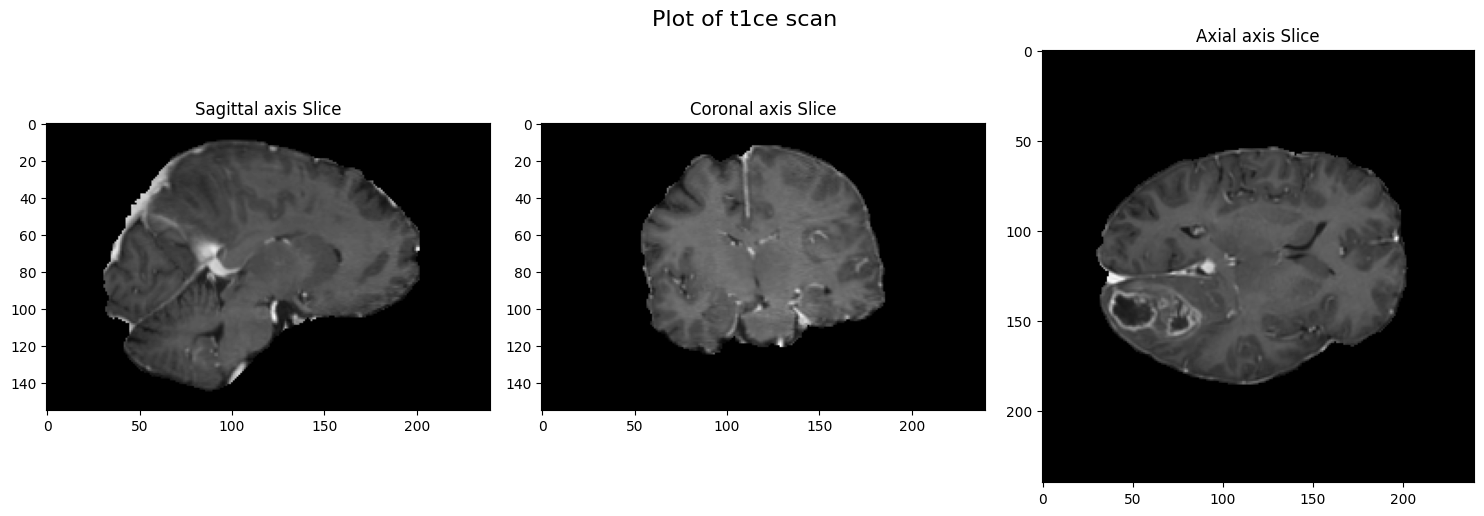

In [6]:
file_path = 'Data\BraTS2021_00495_flair.nii.gz'
image_data_flair = load_nifti(file_path)
plot_image(image_data_flair, 'Plot of flair scan')

file_path = 'Data\BraTS2021_00495_seg.nii.gz'
image_data_seg = load_nifti(file_path)
plot_image(image_data_seg, 'Plot of segmentation')

file_path = 'Data\BraTS2021_00495_t1.nii.gz'
image_data_t1 = load_nifti(file_path)
plot_image(image_data_t1, 'Plot of t1 scan')

file_path = 'Data\BraTS2021_00495_t1ce.nii.gz'
image_data_t1ce = load_nifti(file_path)
plot_image(image_data_t1ce, 'Plot of t1ce scan')

file_path = 'Data\BraTS2021_00495_t2.nii.gz'
image_data_t2 = load_nifti(file_path)
plot_image(image_data_t2, 'Plot of t2 scan')

In [117]:
image_data_flair.shape

(240, 240, 155)

In [ ]:
plot_image_video(image_data_flair,title = '00495 flair scan', file_title='Images_and_GIF/BraTS2021_00495_flair.gif')
plot_image_video(image_data_seg,title = '00495 segmentation', file_title='Images_and_GIF/BraTS2021_00495_seg.gif')
plot_image_video(image_data_t1,title = '00495 t1 scan', file_title='Images_and_GIF/BraTS2021_00495_t1.gif')
plot_image_video(image_data_t1ce,title = '00495 t1ce scan', file_title='Images_and_GIF/BraTS2021_00495_t1ce.gif')
plot_image_video(image_data_t2,title = '00495 t2 scan', file_title='Images_and_GIF/BraTS2021_00495_t2.gif')

## SynthRAD2023

### Task 1

In [8]:
ct_image = load_nifti('Data/Task1/brain/1BA001/ct.nii.gz')
mask = load_nifti('Data/Task1/brain/1BA001/mask.nii.gz')
mr_image = load_nifti('Data/Task1/brain/1BA001/mr.nii.gz')

In [ ]:
plot_image_video(ct_image, title = '001 ct scan',  file_title='Images_and_GIF/SynthRAD2023_1B001_ct.gif')
plot_image_video(mask, title = '001 mask',  file_title='Images_and_GIF/SynthRAD2023_1B001_mask.gif')
plot_image_video(mr_image, title = '001 mr scan',  file_title='Images_and_GIF/SynthRAD2023_1B001_mr.gif')


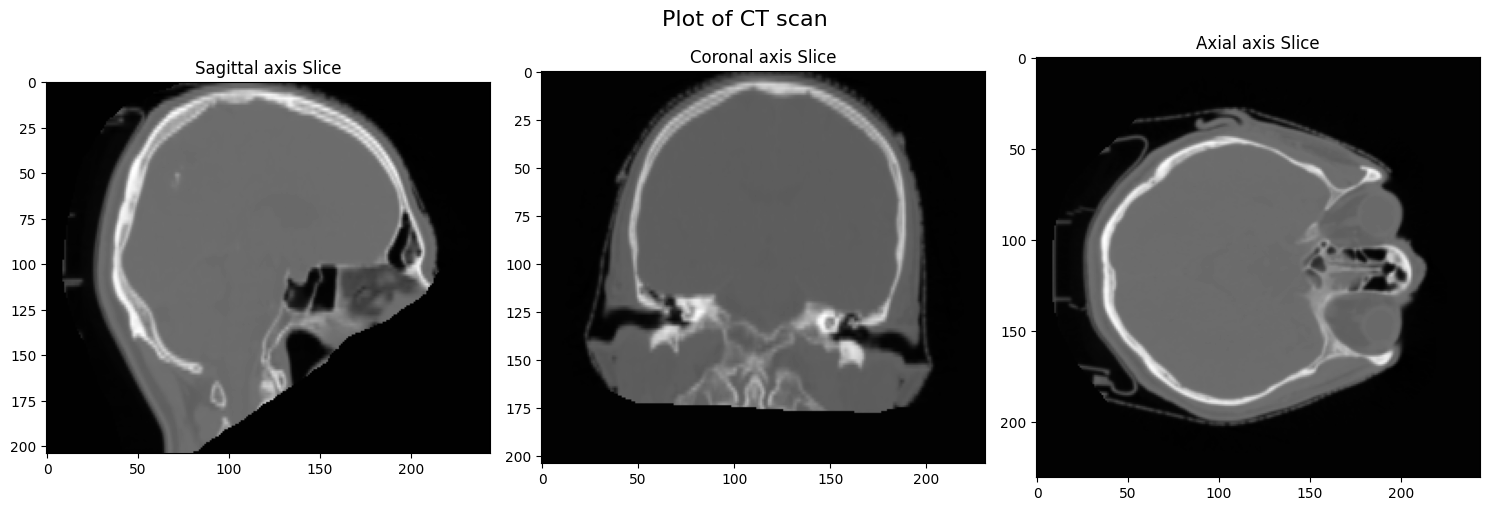

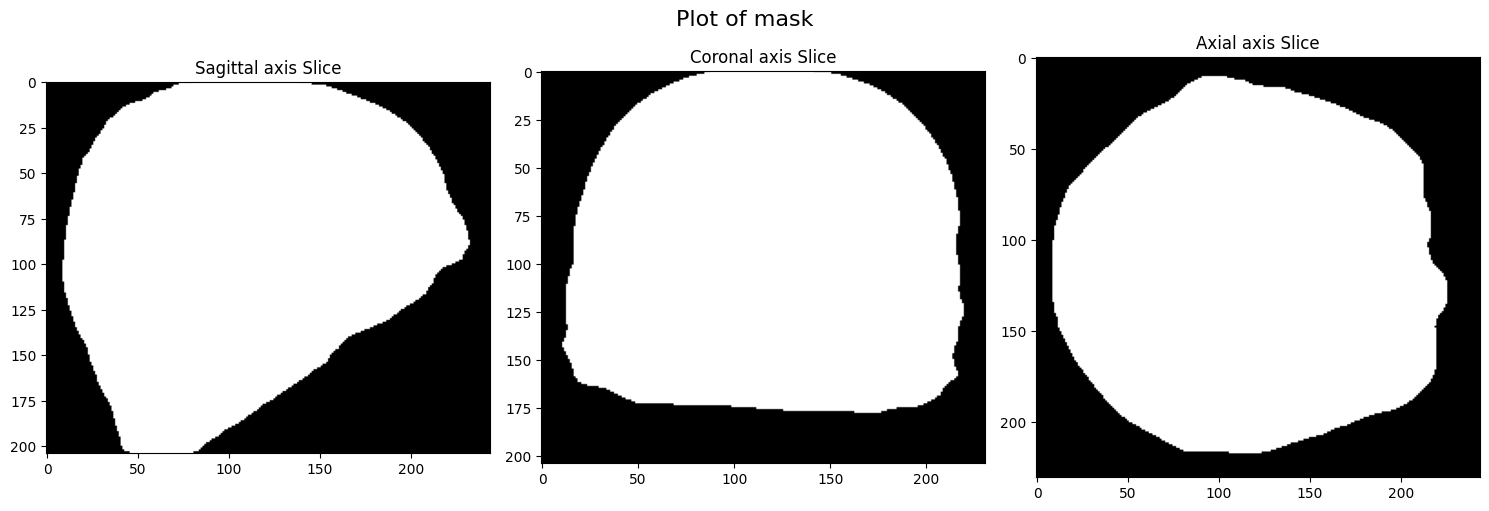

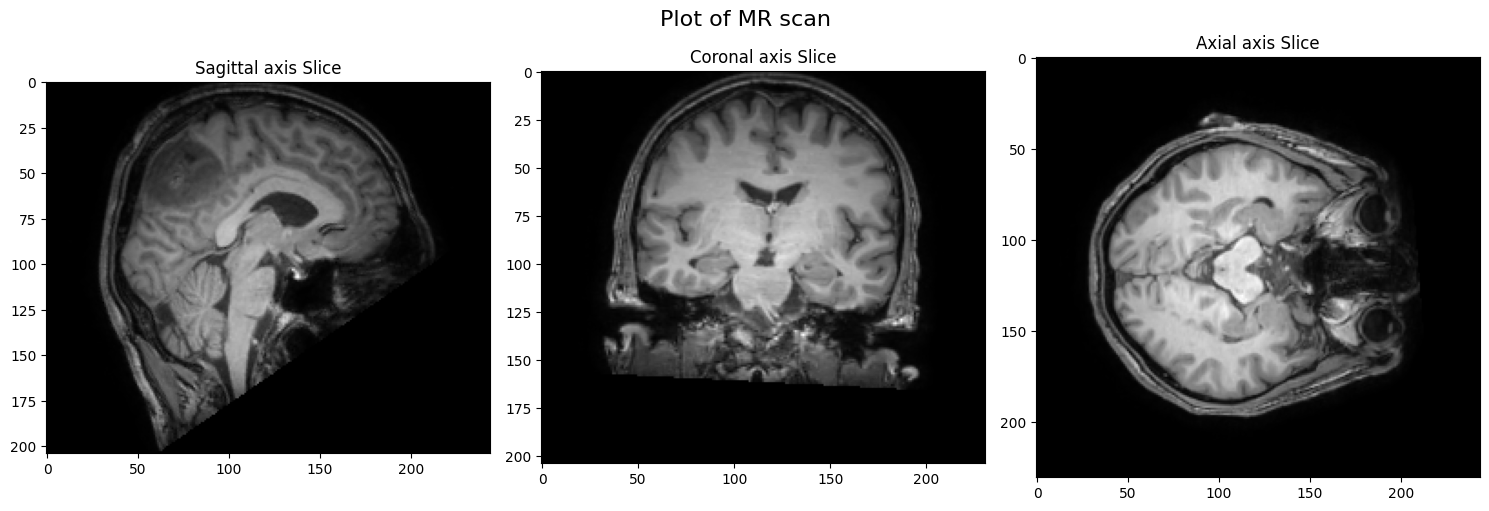

In [10]:
plot_image(ct_image, 'Plot of CT scan')
plot_image(mask, 'Plot of mask')
plot_image(mr_image, 'Plot of MR scan')

### Task 2

In [11]:
cbct_image2 = load_nifti('Data/Task2/brain/2BA001/cbct.nii.gz')
ct2 = load_nifti('Data/Task2/brain/2BA001/ct.nii.gz')
mask2 = load_nifti('Data/Task1/brain/1BA001/mask.nii.gz')

In [ ]:
plot_image_video(cbct_image2, title = '001 cbct scan',  file_title='Images_and_GIF/SynthRAD2023_2BA001_cbct.gif')
plot_image_video(ct2, title = '001 ct scan',  file_title='Images_and_GIF/SynthRAD2023_2BA001_ct.gif')
plot_image_video(mask, title = '001 mask',  file_title='Images_and_GIF/SynthRAD2023_2BA001_mask.gif')

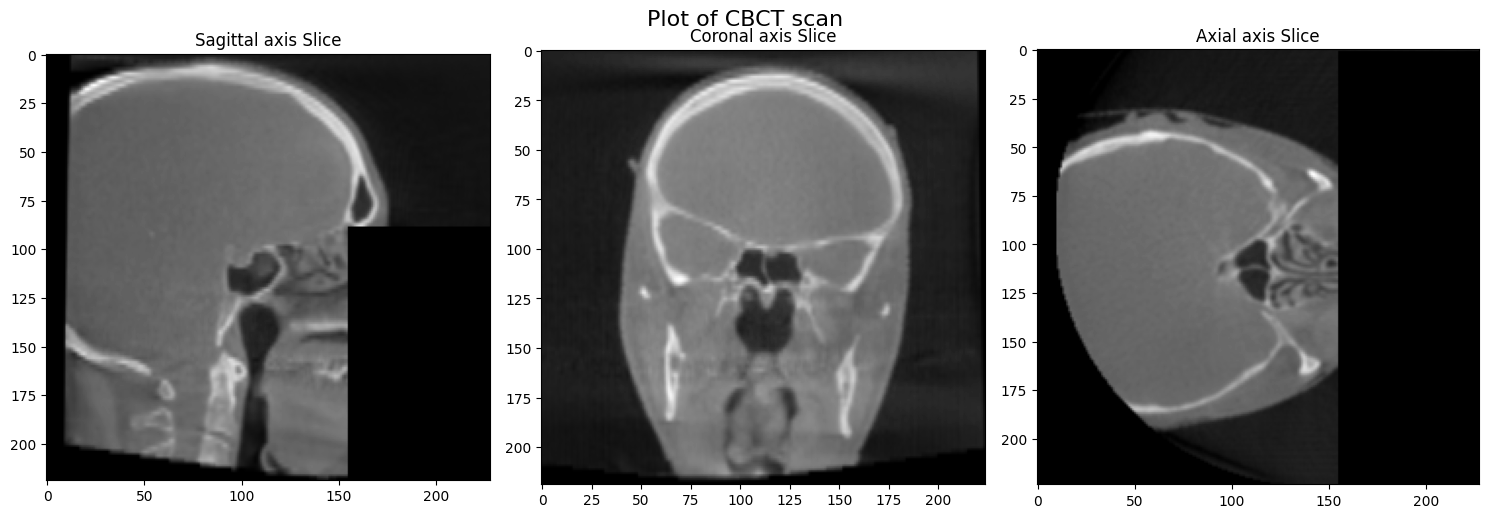

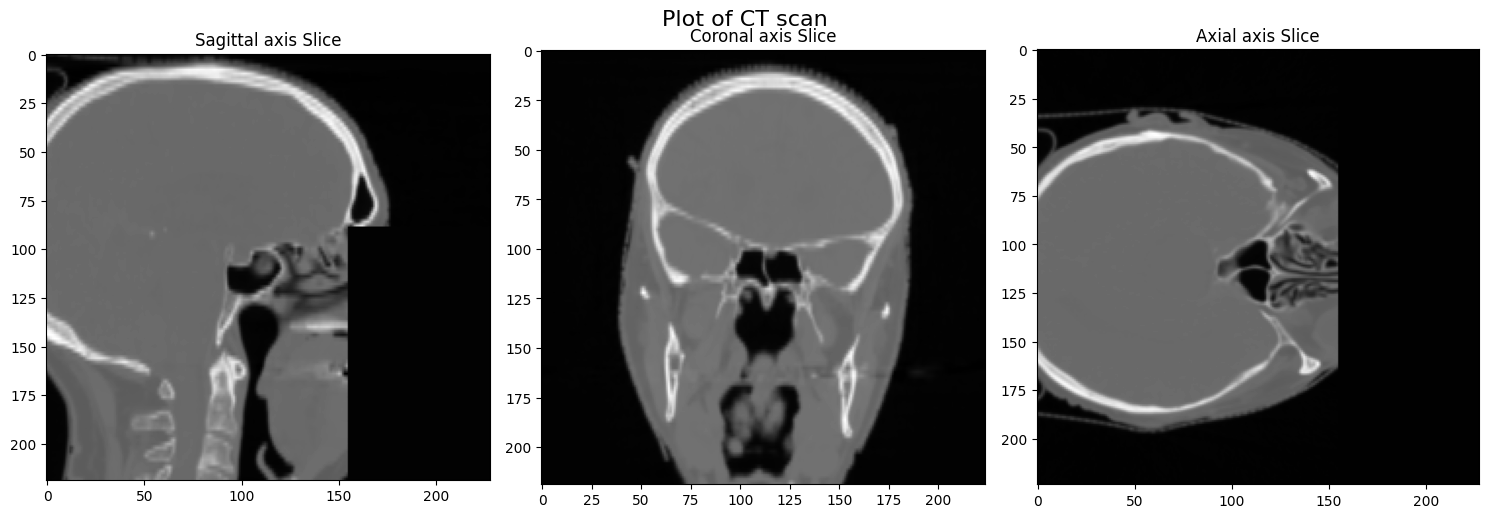

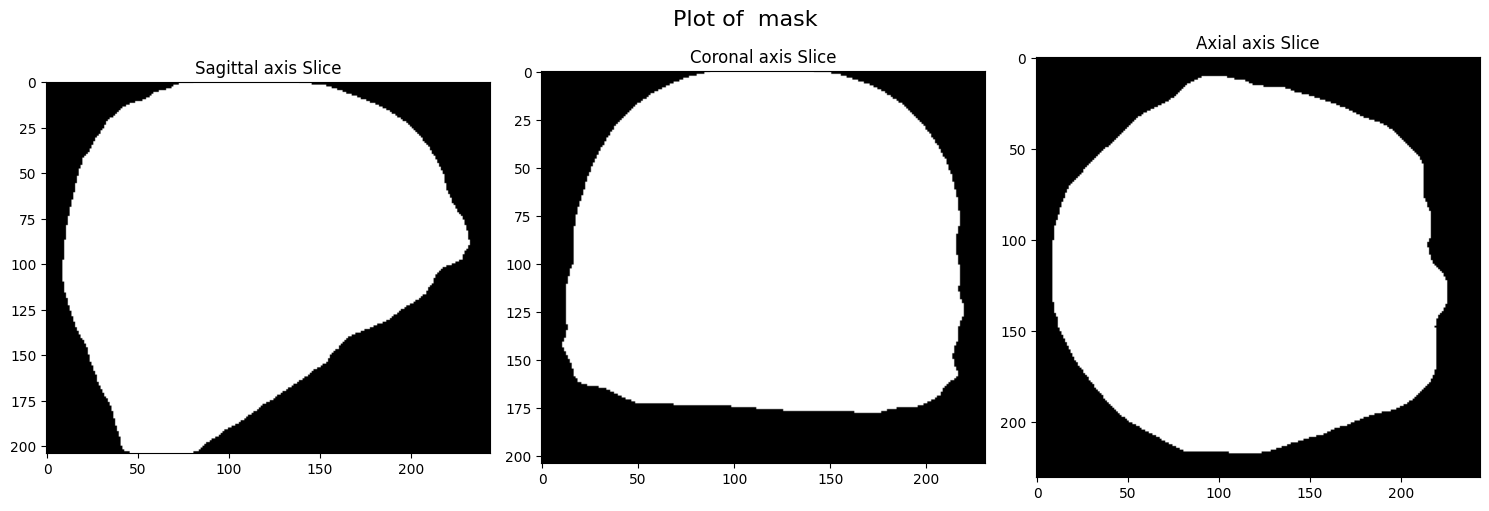

In [13]:
plot_image(cbct_image2, 'Plot of CBCT scan')
plot_image(ct2, 'Plot of CT scan')
plot_image(mask2, 'Plot of  mask')

## ADNI1-screening



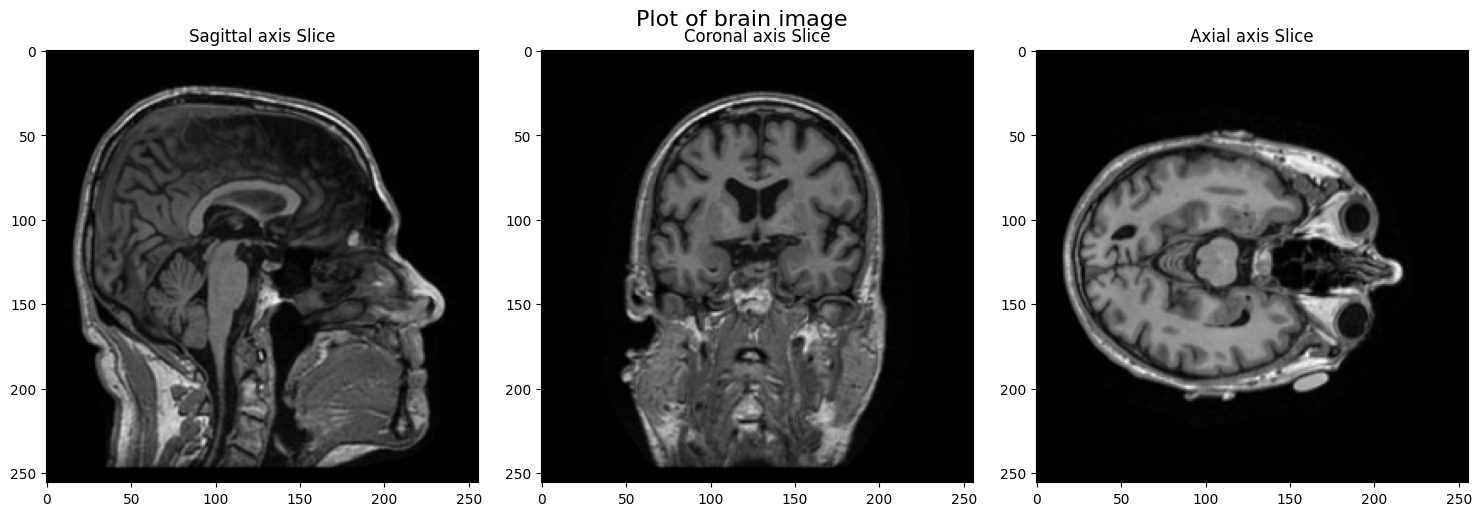

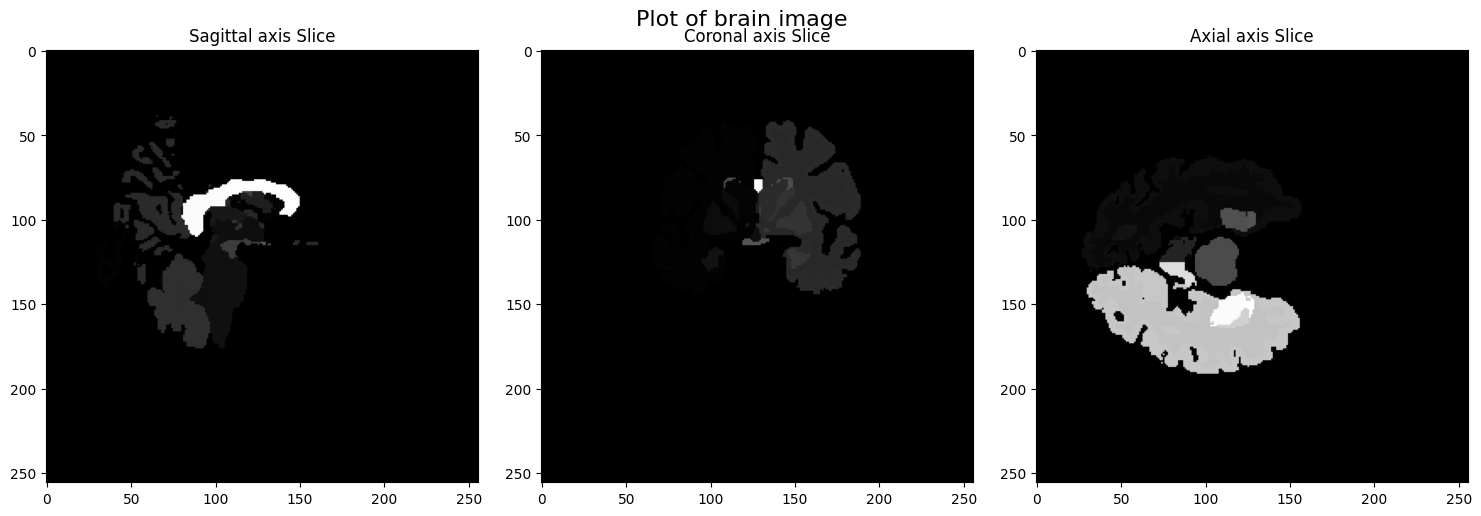

In [17]:
file_path = 'Data/Images-FreeSurfer/002_S_0295_I45108_0000.nii.gz'
image_data_scan = load_nifti(file_path)
plot_image(image_data_scan)

file_path = 'Data/Labels-FreeSurfer/002_S_0295_I45108.nii.gz'
image_data_mask = load_nifti(file_path)
plot_image(image_data_mask)

In [ ]:
plot_image_video(image_data_scan, title = 'Adni1 scan', file_title='Images_and_GIF/Adni1_scan.gif')
plot_image_video(image_data_mask, title = 'Adni1 label', file_title='Images_and_GIF/Adni1_mask.gif')

# Data preprocessing


In [20]:
data_path_dict = get_file_paths()

## Head orientation


We will use RAS head orientation. This means that the first dimension will orient towards the right of the head, The second dimension will orient towards the anterior (front) of the head and the third dimension will orient towards the superior (top) of the head.

In [21]:
axis_codes_brats = []
axis_codes_synth = []
axis_codes_adni = []

for file_path in data_path_dict['BraTS2021']['t1']:
    img = nib.load(file_path)
    axis_codes_brats.append(aff2axcodes(img.affine))



for file_path in data_path_dict['SynthRAD2023']['task1']['mr']:
    img = nib.load(file_path)
    axis_codes_synth.append(aff2axcodes(img.affine))



for file_path in data_path_dict['Adni1']['images']:
    img = nib.load(file_path)
    axis_codes_adni.append(aff2axcodes(img.affine))






In [22]:
data = axis_codes_brats + axis_codes_synth + axis_codes_adni

In [27]:
np.unique(axis_codes_brats, return_counts=True),np.unique(axis_codes_synth, return_counts=True),np.unique(axis_codes_adni, return_counts=True)

((array(['L', 'P', 'S'], dtype='<U1'), array([1251, 1251, 1251], dtype=int64)),
 (array(['L', 'P', 'S'], dtype='<U1'), array([180, 180, 180], dtype=int64)),
 (array(['A', 'I', 'L'], dtype='<U1'), array([503, 503, 503], dtype=int64)))

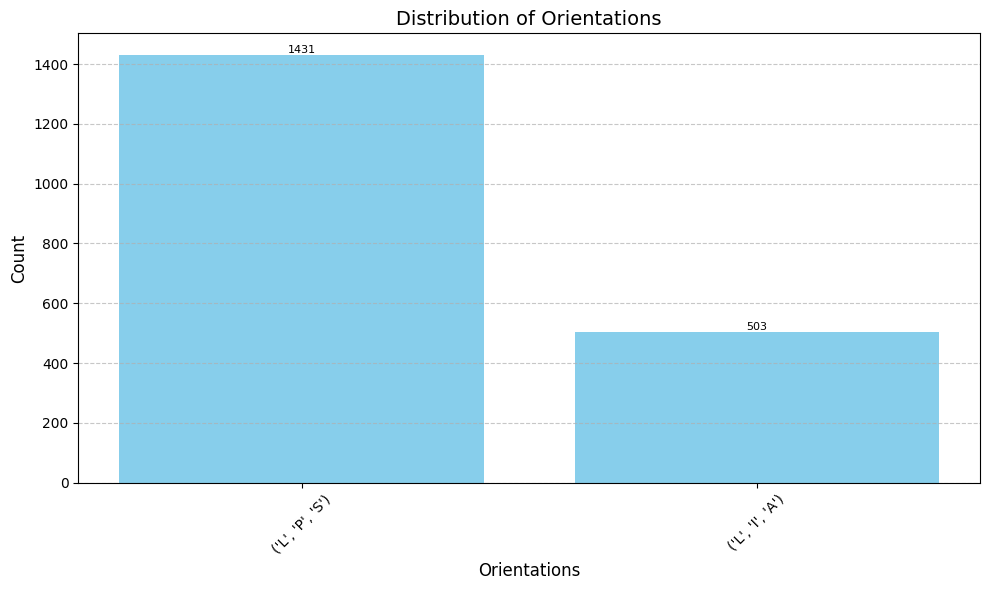

In [35]:
from collections import Counter
import matplotlib.pyplot as plt

data = axis_codes_brats + axis_codes_synth + axis_codes_adni

counts = Counter(data)


unique_tuples, tuple_counts = zip(*counts.items())


plt.figure(figsize=(10, 6))  
bars = plt.bar(range(len(unique_tuples)), tuple_counts, color='skyblue') 

plt.grid(axis='y', linestyle='--', alpha=0.7)


plt.xticks(range(len(unique_tuples)), unique_tuples, rotation=45, fontsize=10) 
plt.yticks(fontsize=10)

plt.xlabel('Orientations', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Distribution of Orientations', fontsize=14)


for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height}', ha='center', va='bottom', fontsize=8)

plt.tight_layout() 
plt.show()


We see that for the BraTS2021 dataset all images are in LPS orientation. In the SynthRAD2023 dataset it is also in LPS orientation. In the Adni1 dataset they are all in AIL orientation

We convert the images to RAS orientation using the make_RAS function implemented in the load_nifti function

In [134]:
image_file = data_path_dict['BraTS2021']['t1'][0]
image = nib.load(image_file)#.get_fdata()
ras_image = make_RAS(image)#load_nifti(image_file)

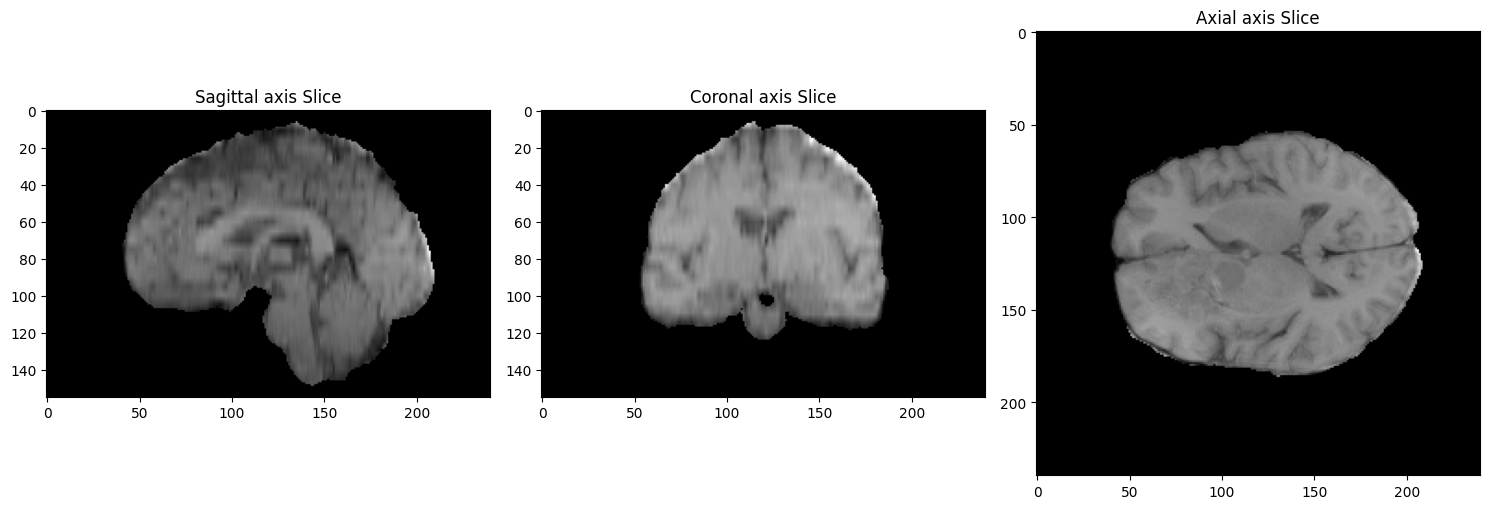

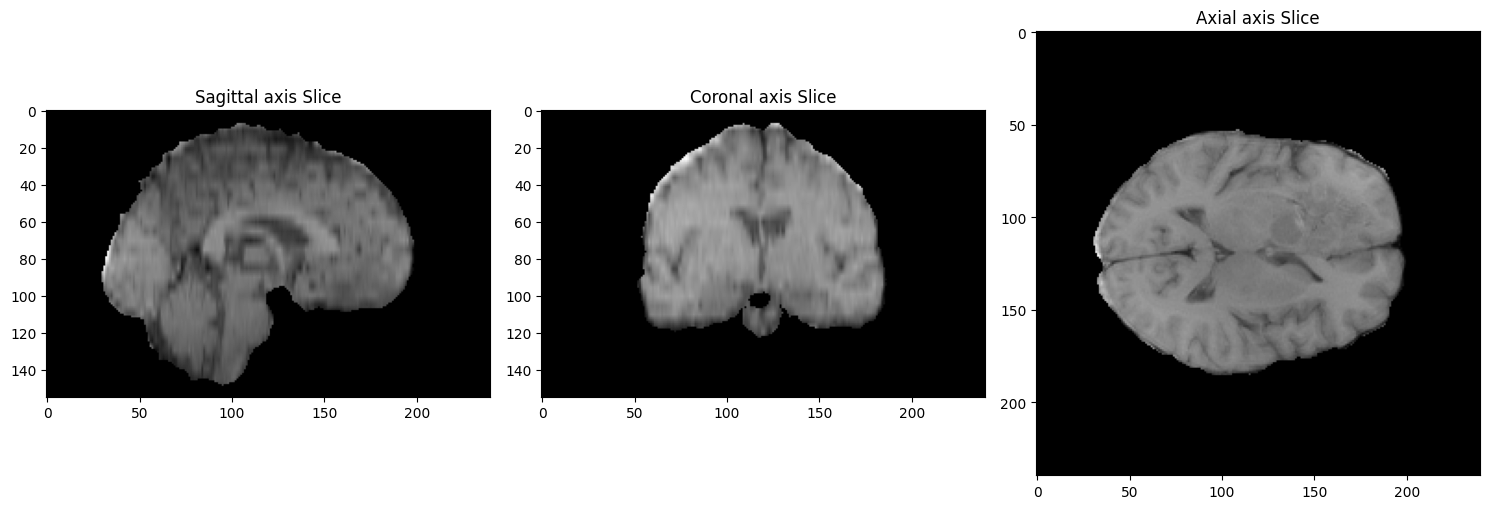

In [136]:
plot_image(image_data=image.get_fdata(), titel='')#'Image in LPS orientation')
plot_image(ras_image, titel='')#'Image convertet to RAS orientation')

## Meta data

In [ ]:
file = nib.load(data_path_dict['BraTS2021']['t1'][0])
print_meta(file)

In [414]:
file = data_path_dict['BraTS2021']['t1'][0]
org_file = nib.load(file)
mod_file = prep(file)

In [185]:
files = data_path_dict['All_data']
meta_data = {}
for nifti_file_path in files:
    img = sitk.ReadImage(nifti_file_path)
    metadata_keys = img.GetMetaDataKeys()
    for key in metadata_keys:
        if key not in meta_data:
            meta_data[key] = []
        value = img.GetMetaData(key)
        meta_data[key].append(value) 


In [47]:
sagittal, sagittal_slice, coronal, coronal_slice, axial, axial_slice, indexes = data_shapes()

In [89]:
indexes

[1251, 503, 180]

In [104]:
sag_brats = sagittal_slice[:1251]
cor_brats = coronal_slice[:1251]
ax_brats = axial_slice[:1251]
brats_total = sag_brats+cor_brats+ax_brats

sag_synth = sagittal_slice[1251:1251+503]
cor_synth = coronal_slice[1251:1251+503]
ax_synth = axial_slice[1251:1251+503]
synth_total = sag_synth+cor_synth+ax_synth

sag_adni = sagittal_slice[1251+503:]
cor_adni = coronal_slice[1251+503:]
ax_adni = axial_slice[1251+503:]
adni_total = sag_adni+cor_adni+ax_adni

In [108]:
np.var(sag_brats),np.var(cor_brats), np.var(ax_brats)


(0.0, 0.0, 0.0)

C:\Users\karlr\AppData\Local\Temp\ipykernel_18812\1152925748.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Category', y='Values', data=df, palette=['skyblue', 'lightgreen', 'lightcoral'])


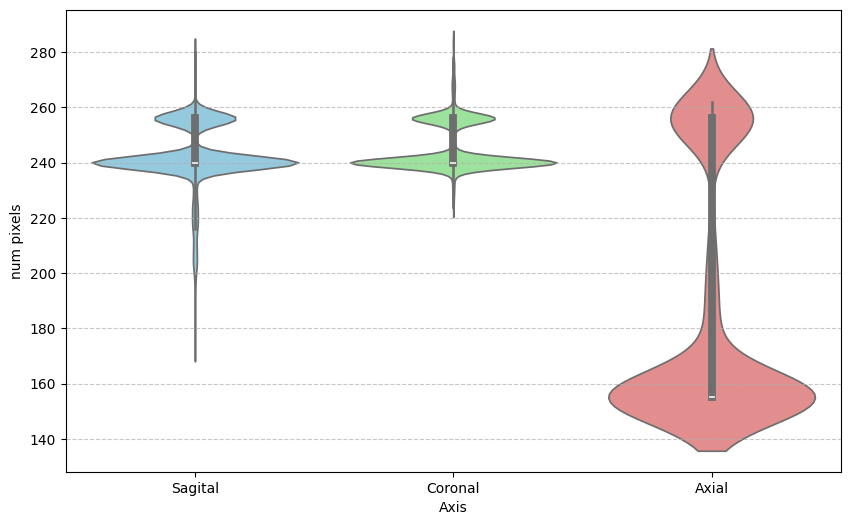

In [55]:
violin_plot([sagittal, coronal, axial], y_label='num pixels', titel = '')

C:\Users\karlr\AppData\Local\Temp\ipykernel_18812\1152925748.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Category', y='Values', data=df, palette=['skyblue', 'lightgreen', 'lightcoral'])


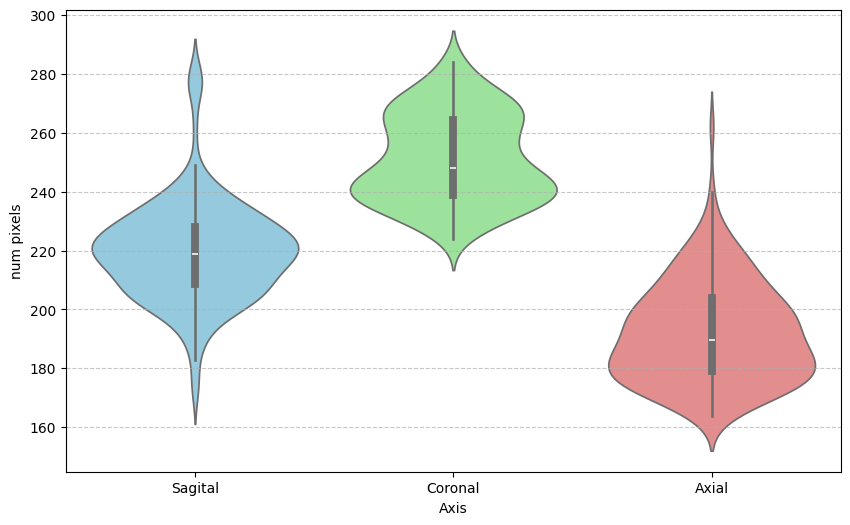

In [56]:
violin_plot([sagittal[indexes[0]+indexes[1]:], coronal[indexes[0]+indexes[1]:], axial[indexes[0]+indexes[1]:]], y_label='num pixels', titel = '')

C:\Users\karlr\AppData\Local\Temp\ipykernel_18812\1152925748.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame({'Category': [label]*len(values), 'Values': values})], ignore_index=True)
C:\Users\karlr\AppData\Local\Temp\ipykernel_18812\1152925748.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Category', y='Values', data=df, palette=['skyblue', 'lightgreen', 'lightcoral'])


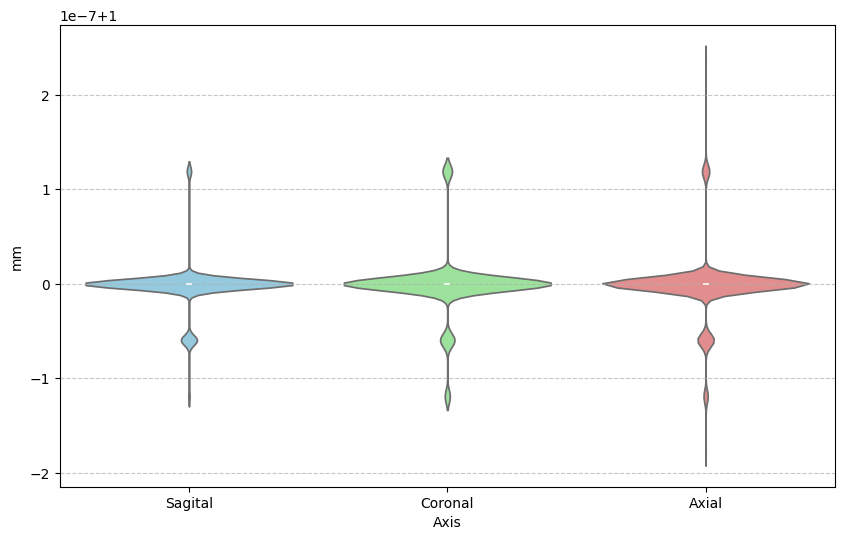

In [57]:
violin_plot([sagittal_slice, coronal_slice, axial_slice], y_label='mm', titel = '')

## Resolution changing

In [49]:
file = data_path_dict['SynthRAD2023']['task1']['mr'][28]
nifti_img = make_RAS(nib.load(file))
pad_img = load_nifti(file)

In [51]:
nifti_img.shape

(231, 265, 202)

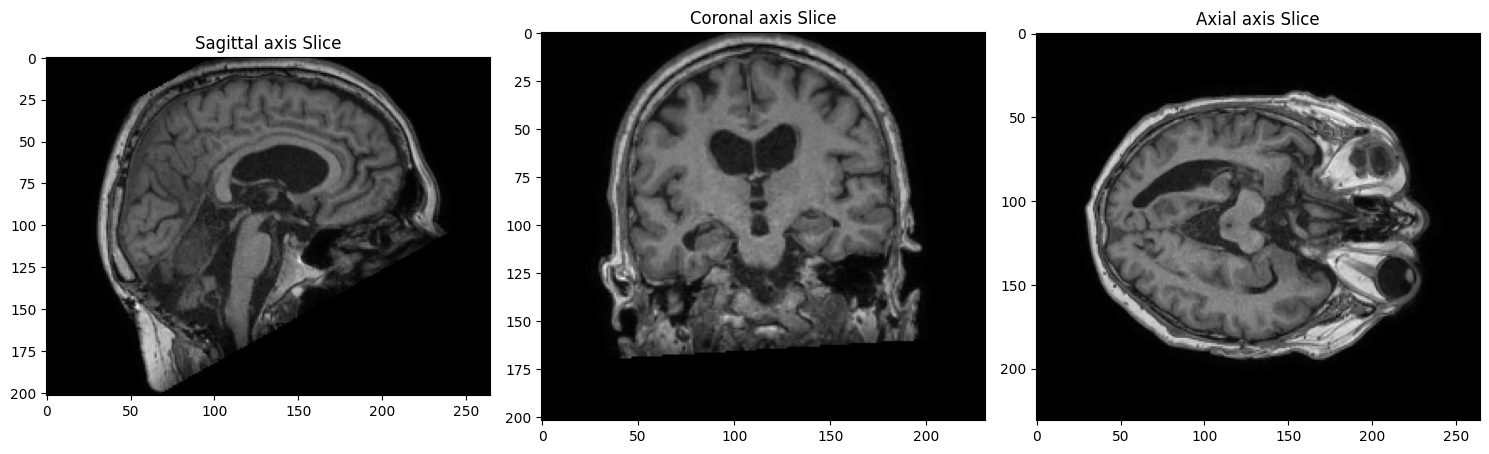

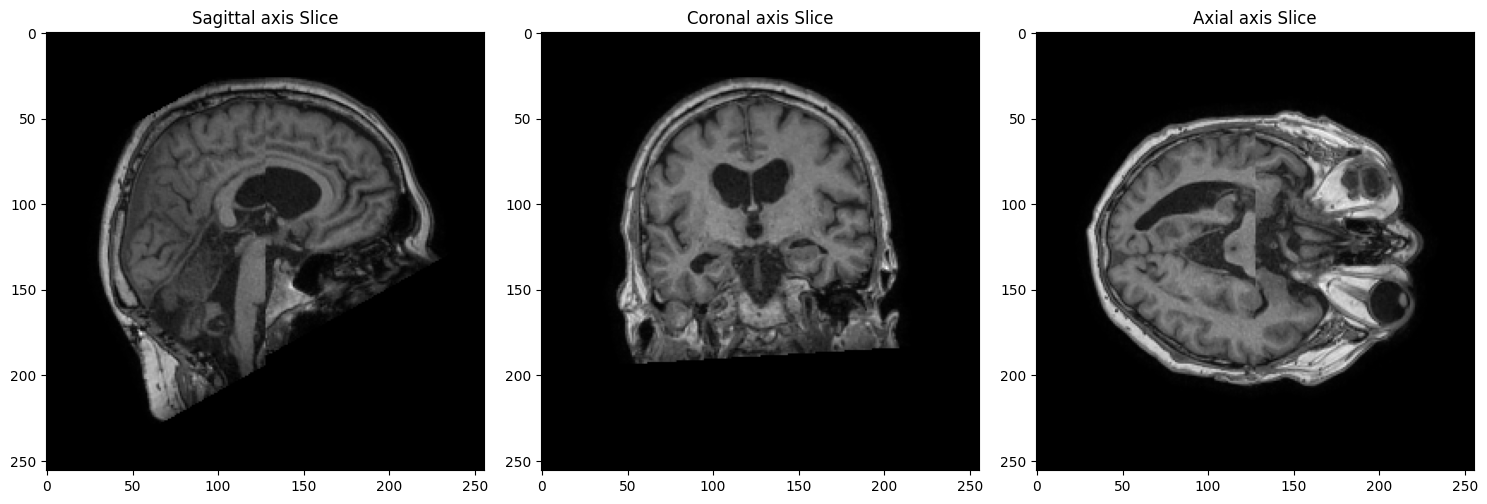

In [53]:
plot_image(nifti_img, titel='')#f'Image of shape {nifti_img.shape}')
plot_image(pad_img, titel='')#f'Image of shape {pad_img.shape}')

## Train test split

In [426]:
file_paths_flair = data_path_dict['BraTS2021']['flair']
file_paths_t1ce = data_path_dict['BraTS2021']['t1ce']
file_paths_t2 = data_path_dict['BraTS2021']['t2']
file_paths_t1 = data_path_dict['BraTS2021']['t1']
labels = data_path_dict['BraTS2021']['seg']
indexes = list(range(len(labels)))
train_indexes, test_indexes, train_labels, test_labels = train_test_split(indexes, labels, test_size=0.1, random_state=42)

# Models


## Med-DDPM


In [120]:
sample0 = load_nifti('Data/Samples/ddim/image/sample_0.nii.gz')
sample1 = load_nifti('Data/Samples/ddim/image/sample_1.nii.gz')
sample2 = load_nifti('Data/Samples/ddim/image/sample_2.nii.gz')
sample3 = load_nifti('Data/Samples/ddim/image/sample_3.nii.gz')

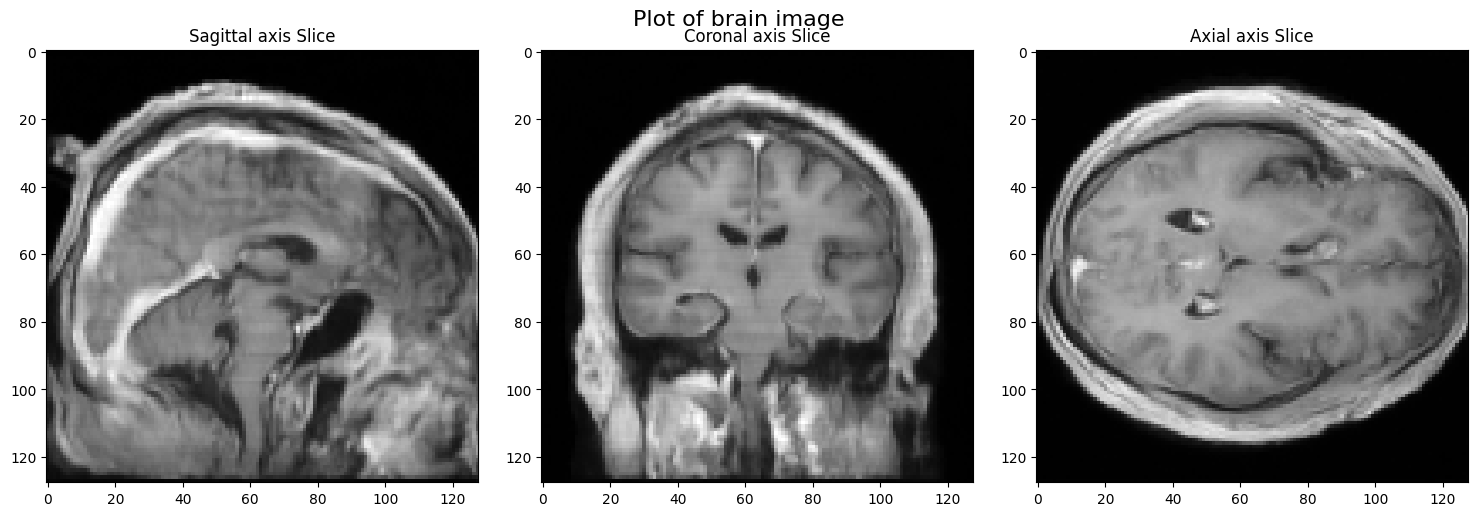

In [121]:
plot_image(sample0)
plot_image(sample1)
plot_image(sample2)
plot_image(sample3)

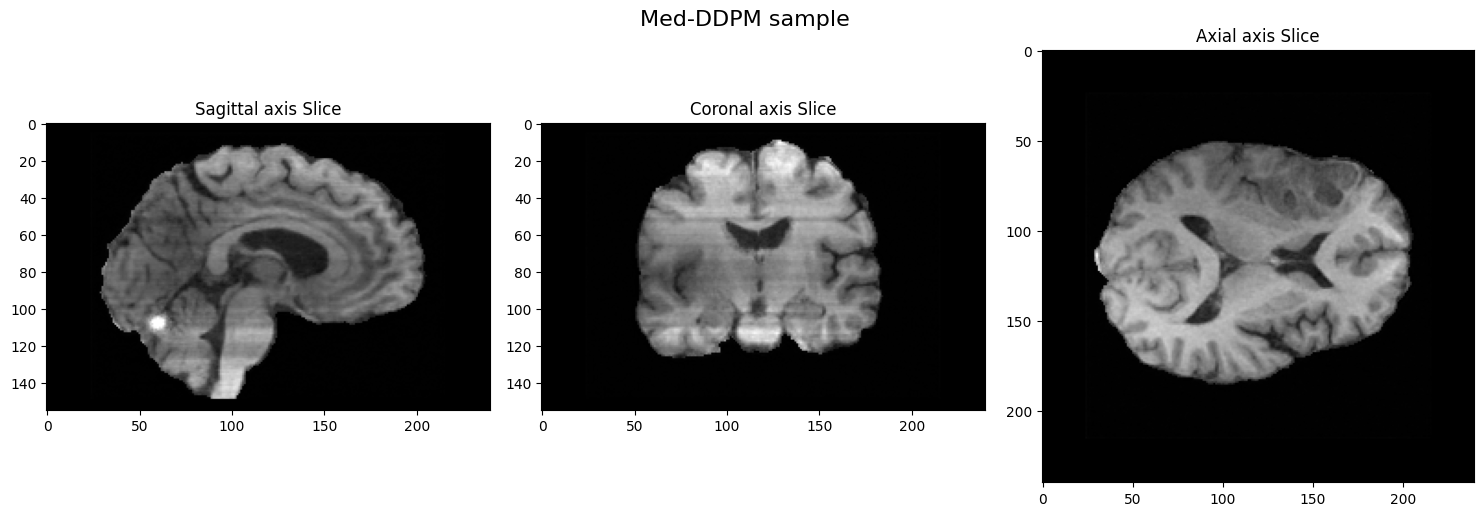

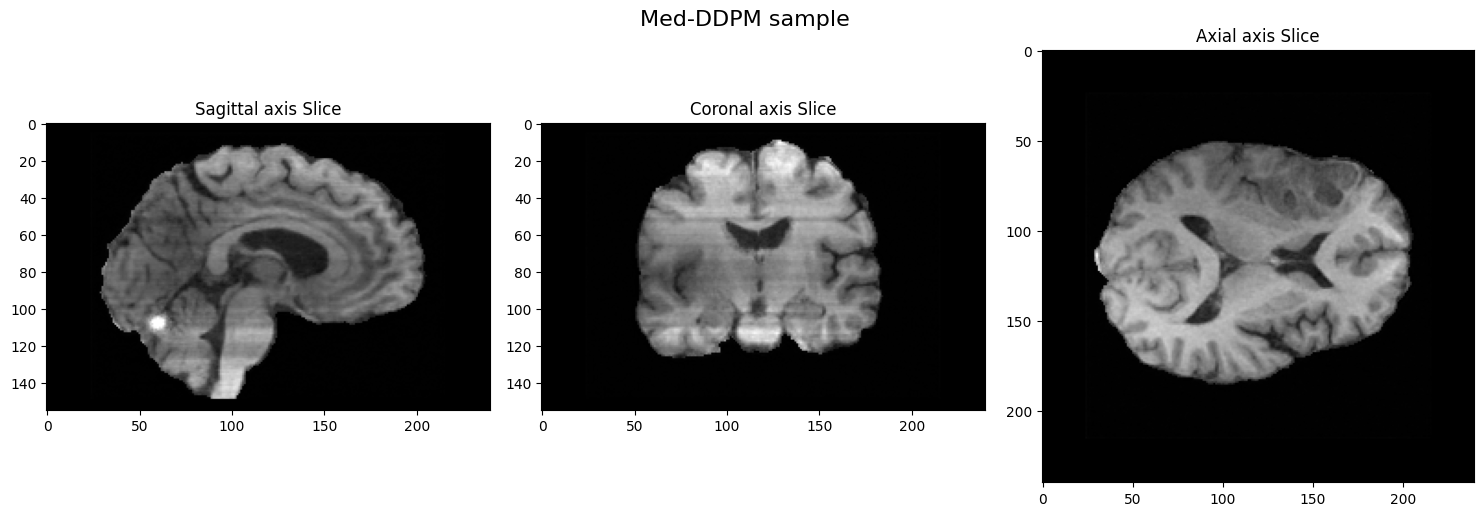

In [142]:
image_file0 = 'Data/Samples/brats_med_ddpm/exports/t1/1_BraTS2021_00529_t1.nii.gz'
image0 = load_nifti(image_file)
plot_image(image0, titel='Med-DDPM sample')
image_file1 = 'Data/Samples/brats_med_ddpm/exports/t1/1_BraTS2021_01306_t1.nii.gz'
image1 = load_nifti(image_file)
plot_image(image1, titel='Med-DDPM sample')

MovieWriter imagemagick unavailable; using Pillow instead.


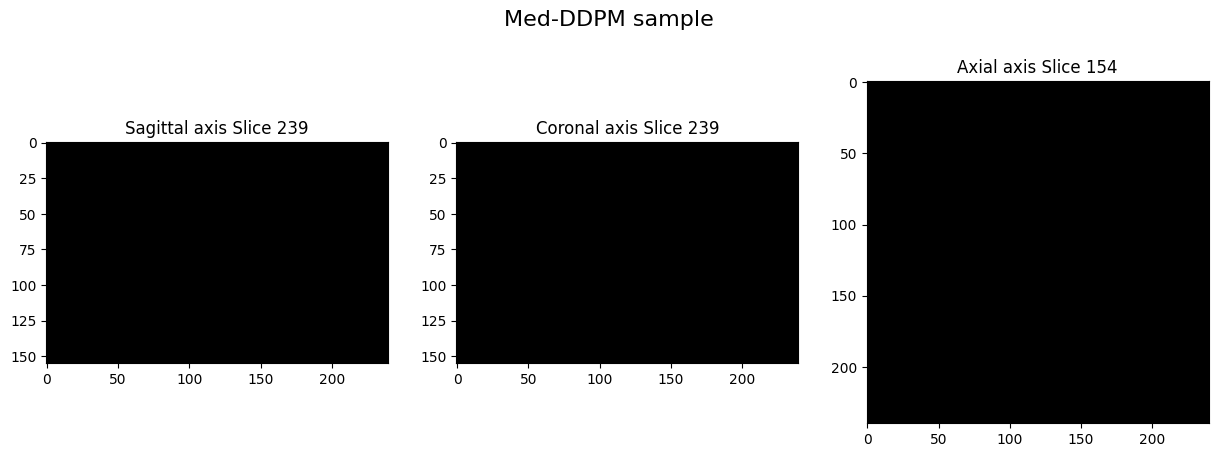

In [143]:
plot_image_video(image0,title = 'Med-DDPM sample', file_title='Images_and_GIF/BraTS2021_med_DDPM_sample.gif')

## WDM

In [76]:
file_path = data_path_dict['SynthRAD2023']['task1']['mr'][0]#'C:\Studiet\Bachelor projekt\wdm-3d-main\sample_10_0.nii.gz'#data_path_dict['Adni1']['images'][0]#"C:\Studiet\Bachelor projekt\wdm-3d-main\sample_24_0.nii.gz"
image_data = load_nifti(file_path)
#plot_image_video(image_data, file_title='wdm4.gif')

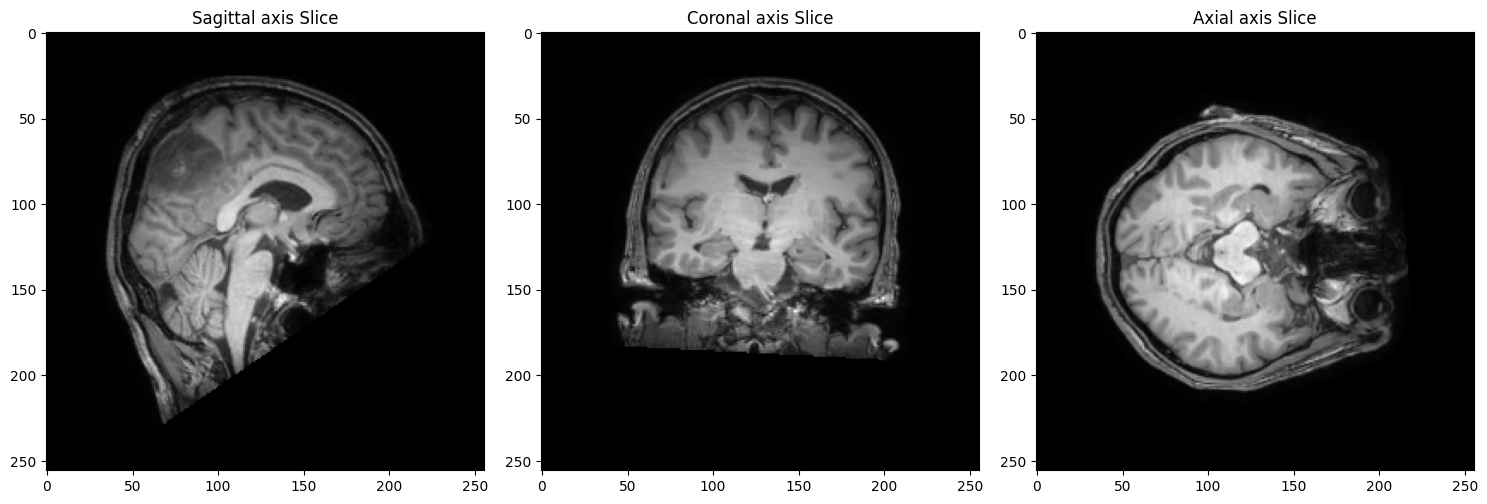

In [77]:
plot_image(image_data, titel='')

In [42]:
file_path = 'Code\wdm-3d-main\sample_0_0.nii.gz'
image_data = load_nifti(file_path)

In [43]:
plot_image(image_data)

## Training stats


In [57]:
data1 = np.genfromtxt('brats_train_stats.csv', delimiter=',', skip_header=1)
data2 = np.genfromtxt('adni_train_stats.csv', delimiter=',', skip_header=1)
data3 = np.genfromtxt('synthrad_train_stats.csv', delimiter=',', skip_header=1)

In [83]:
i = 1750
x_brats = data1[:, 6][2:][:i]
x_adni = data2[:, 6][2:][:i]
x_synthrad = data3[:, 6][2:][:i]

mse_wav_brats = data1[:, 0][2:][:i]
mse_wav_adni = data2[:, 0][2:][:i]
mse_wav_synthrad = data3[:, 0][2:][:i]




colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
markers = ['o', 's', 'D', '^', 'v']


plt.figure(figsize=(12, 8))


plt.plot(x_brats,mse_wav_brats, marker=markers[0], markersize=6, linestyle='-', linewidth=2, color=colors[0], label='MSE BraTS2021')
plt.plot(x_adni, mse_wav_adni, marker=markers[1], markersize=6, linestyle='--', linewidth=2, color=colors[1], label='MSE ADNI1-screening')
plt.plot(x_synthrad, mse_wav_synthrad, marker=markers[2], markersize=6, linestyle='-.', linewidth=2, color=colors[2], label='MSE SynthRAD2023')


plt.xlabel('Number of Iterations', fontsize=14)
plt.ylabel('Mean Squared Error (MSE)', fontsize=14)

plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)


plt.minorticks_on()
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')


plt.tight_layout()  
plt.show()

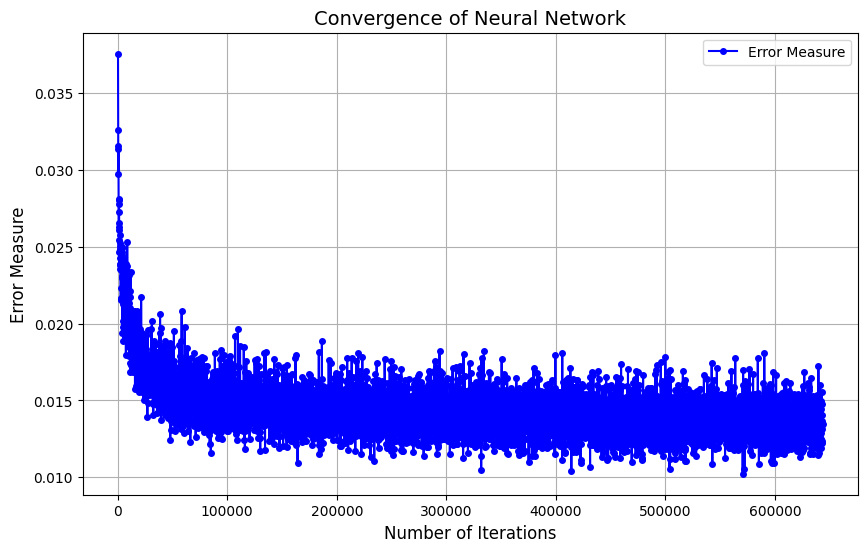

In [41]:
y = data[:, 4][2:]
x = data[:, 6][2:]


plt.figure(figsize=(10, 6))  
plt.plot(x, y, marker='o', markersize=4, linestyle='-', color='b', label='Error Measure')


plt.xlabel('Number of Iterations', fontsize=12)
plt.ylabel('Error Measure', fontsize=12)
plt.title('Convergence of Neural Network', fontsize=14)
plt.legend()
plt.grid(True)


plt.show()

In [30]:
brats400_SSIM = [0.8629328016902271, 0.8982034843490897, 0.8906402938155056, 0.8907608894537103, 0.8949570918130134, 0.9015876918877583, 0.8894432160968232, 0.8900159592962109, 0.9015154299326084, 0.9028558559353418, 0.8975816379333789, 0.8986493425729656, 0.8917921825898328, 0.8924547175776514, 0.9008534438899877, 0.8892309393485185, 0.8911658103725478, 0.900804712185388, 0.8898840753387548, 0.8754839967216278, 0.8948921040549301, 0.8960610717347711, 0.9036370088875336, 0.9038117504926872, 0.8998813568806775, 0.9004853315421505, 0.8973489608224299, 0.9016939796082908, 0.8981136990595212, 0.9016533480686186, 0.9079105365472281, 0.9031566258681387, 0.8883982226186309, 0.8934628883045215, 0.9004358157713098, 0.8890092685076489, 0.898381072988885, 0.8941202977185033, 0.9046561436355076, 0.9093419395237681, 0.8852490688849608, 0.8883701232629769, 0.8913596450097475, 0.8938459408546992, 0.9020719260480767, 0.9030311612379606, 0.8970395772009604, 0.8981389449618736, 0.9030653629754068, 0.9018216666206585, 0.8927694879943747, 0.8955767206936358, 0.9083525958514371, 0.9036402806751579, 0.8949164525340186, 0.899707237916598, 0.9060275977972747, 0.9042393958563643, 0.8943694908220837, 0.9016894885744657, 0.8905903365087112, 0.8938441191250801, 0.8990019201628812, 0.8898545731112654, 0.8953574837779393, 0.8888011011746326, 0.9033798896371361, 0.9022016403263989, 0.8897238498213652, 0.9066735516495248, 0.8960943859356184, 0.9010656985614666, 0.8976027633156455, 0.8929075474118908, 0.8848343078471341, 0.8862052913374601, 0.8887932767736463, 0.894697517689478, 0.9039462334449218, 0.89442340858605, 0.8875601466979866, 0.8903198729029413, 0.8884052138354912, 0.9060988528583865, 0.8993491719702129, 0.884101821829422, 0.8777274924841955, 0.8872772270743546, 0.9024474856949253, 0.9085163335687362, 0.8990427864687656, 0.9010129421262951, 0.896829294921821, 0.8931484907091943, 0.8894935863806687, 0.8949430153365717, 0.8915370190273224, 0.8866618972252702, 0.9044120560975059, 0.8887223334829304, 0.888557326011531, 0.9044246705207507, 0.899403503394199, 0.897398686360981, 0.9065556077479213, 0.8997007838851554, 0.8925791991770413, 0.8935439514911234, 0.9004001397194142, 0.9032907823843326, 0.8845297770512746, 0.9056549035558631, 0.8992090330259818, 0.9046243667312016, 0.8933294659850837, 0.8893476324943012, 0.894326370988954, 0.9029433172183748, 0.8977909496111623, 0.8952077224968955, 0.8911453126711543, 0.9008565543177276, 0.8857155844682825, 0.8941554057783049, 0.8878891358584788, 0.8923276693307173]
brats400_PSNR = [16.657498935549544, 20.113777216665344, 18.365233510863614, 19.063147976023277, 19.521870244631504, 20.700805484105015, 19.34836182055187, 18.860219088845348, 21.880910744486755, 21.198489589191535, 19.874578503702487, 20.758385691007337, 18.175961003859232, 19.53913963699072, 20.54753882190849, 17.502489746939474, 19.32774792101657, 20.29054410079713, 19.45481590276486, 17.266684795395555, 18.017412710207775, 20.913746327876606, 21.046757082524337, 22.409961063867236, 18.662264699676246, 19.900199853132253, 19.355973049067675, 18.25173074827991, 21.727550569031727, 18.75990310789138, 19.12105836492185, 18.571483732332602, 19.66420352843262, 19.18521860970004, 18.39285082888668, 19.248942522117613, 22.240039750901243, 19.401251284928303, 20.364379555130405, 21.664354607957836, 17.670134982261125, 18.160082971420437, 17.83482905614714, 18.900825365655262, 21.054671533435766, 18.829697215005762, 19.767680711295274, 19.67058431760591, 18.463395162088133, 20.196408935126094, 18.93770107227018, 19.19231680840295, 21.472718143775115, 18.854493886733767, 20.60578764766989, 20.31394854914827, 21.621971552850884, 22.642750455861794, 21.564599309603047, 20.902451374123867, 18.72792559048344, 20.2449915399651, 20.2423368654496, 19.63146206507439, 23.024049855401522, 18.180668615727946, 21.125104910748938, 18.14900794070986, 19.363338805576007, 20.601372755380368, 19.34569368653304, 19.868479616935698, 19.457450604114243, 19.430032024305564, 18.850190223992552, 18.116139448069323, 18.206806786217182, 19.57335122191611, 20.56892563683632, 18.631152261509648, 20.667190733869486, 17.426051402133027, 19.114537745297568, 19.482745781710115, 19.18103897509091, 18.60312675220709, 17.00350945680013, 19.38174114057556, 19.03030773967322, 20.288534707106088, 20.489085747119155, 20.490159181530334, 20.501861679442932, 18.741353121026002, 18.16473873137269, 19.92266632831777, 18.103648850803527, 19.01374030686486, 21.146143075924083, 18.72377110585253, 18.29918031427491, 19.742323597465436, 21.520154690742977, 19.52651707640801, 19.534211633548814, 19.476824653352594, 19.517145014900375, 19.538002205301677, 20.600184561288497, 20.166379685679804, 19.144210197418026, 18.61317615492167, 19.868395264413238, 19.344437292577997, 19.77697327008984, 19.093123107061917, 18.399338306951144, 20.497190255996628, 20.471611552331893, 19.90910570433739, 18.692986236515868, 21.415505512381984, 17.3934927496332, 23.29628569717707, 18.676134767046758, 18.892266519539064]

brats400_BRISQUE = [96.14743304254677, 83.22616900473741, 84.32198562436118, 82.80979835039885, 84.59945617893707, 82.20641531139671, 82.63095572959209, 82.9768497502046, 87.8543826477103, 81.0403407502469, 84.32939272141287, 80.58311432441879, 89.58459197140189, 82.88098137693143, 82.44142295922637, 89.21899686484143, 81.12929006464157, 85.13448693328787, 86.75369669062144, 95.92001819844654, 87.73225666581244, 82.94874614499867, 83.60922101099196, 77.50024628730615, 86.48357213293865, 84.25258933105525, 84.52647714868682, 89.01626909116482, 80.3564058238268, 91.14794805475175, 93.14634255508815, 93.26001495010168, 80.81312497895632, 82.05607411871439, 90.5875545206327, 81.34208836617948, 80.77333371647659, 79.71278347193713, 85.63965374710425, 84.40154662341303, 93.66281590057274, 94.35404232607196, 90.1718760501455, 86.00427006662666, 83.76204207236343, 87.2577841349641, 83.49428523527482, 82.79774380688592, 90.72250666213192, 82.79295957297961, 83.58711047400625, 87.24273954035257, 86.51678376780613, 88.77568858886661, 83.97028065648696, 82.34822644939103, 82.69240805324029, 80.30327600256966, 78.6991715936029, 85.4753062452177, 81.07742652736421, 82.44721586501097, 83.4699315983181, 81.57355152346595, 74.69220704772937, 81.83022752480792, 83.95967497927018, 94.36391218531939, 81.01936538494607, 86.38980526368178, 83.94195380021942, 84.38414633963717, 81.2250331099288, 84.12625826689637, 81.39308665802857, 90.5797423704325, 85.46067067153238, 83.57493863299169, 82.28483808601388, 86.80511151122398, 88.66844280136652, 93.79526781742572, 80.10493194872116, 88.7894453874963, 84.21581954383788, 82.26119987401206, 90.87738295284008, 83.29115660376902, 87.4145115105901, 84.91773458224169, 84.61814858671517, 84.83291141131609, 81.5175627339744, 85.47912444475044, 85.00089635768175, 81.2339297607657, 88.28600916092999, 82.53583654468514, 84.5500386085185, 81.6485862520616, 89.02610126134465, 86.15805952340204, 80.96519260516962, 83.78163224565478, 87.80831967324231, 84.07678399683446, 82.4504541344994, 85.71216598975963, 83.70026958528258, 87.08227990226818, 81.05322336295104, 92.72290473105106, 83.43568180072836, 87.60379065129922, 80.85568974888596, 83.65825478327574, 87.70407480725993, 82.82837072510922, 83.81980441922482, 82.21173753523048, 82.31864065293207, 83.59525654364164, 90.24166309615238, 79.54936554294414, 81.89239674153707, 87.59211680428794]


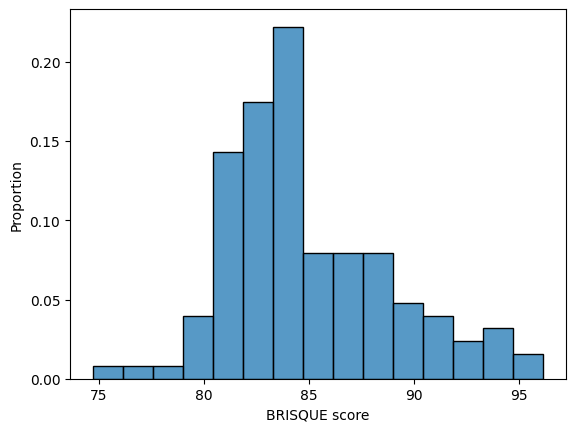

In [31]:
sns.histplot(brats400_BRISQUE, stat='probability', bins=15, kde=False)
plt.xlabel('BRISQUE score')
plt.ylabel('Proportion')
plt.show()

In [32]:
sns.kdeplot(brats400_PSNR, fill=True)
plt.xlabel('PSNR score')
plt.ylabel('count')
plt.show()

In [33]:
sns.histplot(brats400_SSIM, stat='probability', bins=15, kde=False)
plt.xlabel('SSIM score')
plt.ylabel('Proportion')
plt.show()

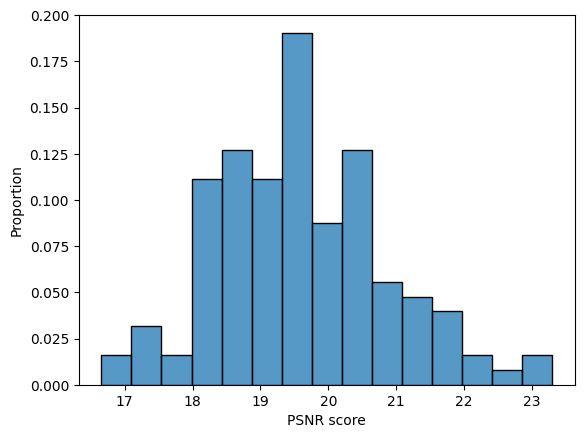

In [34]:
sns.histplot(brats400_PSNR, stat='probability', bins=15, kde=False)
plt.xlabel('PSNR score')
plt.ylabel('Proportion')
plt.show()

## StyleGAN3D


In [ ]:
Brats_train_path = 'Code/3DStyleGAN-master/data/BraTS2021_train'
Brats_test_path = 'Code/3DStyleGAN-master/data/BraTS2021_test'

In [682]:
def make_dataset_GAN():
    train_flair_path = Brats_train_path + '/flair/'
    train_seg_path = Brats_train_path + '/seg/'
    train_t1ce_path = Brats_train_path + '/t1ce/'
    train_t2_path = Brats_train_path + '/t2/'
    print('Generating training set')
    for i in train_indexes:
        flair = prep(file_paths_flair[i])
        nib.save(flair, train_flair_path + f'BraTS2021_{i}_flair.nii.gz')
        seg = prep(labels[i])
        nib.save(seg, train_seg_path + f'BraTS2021_{i}_seg.nii.gz')
        t1ce = prep(file_paths_t1ce[i])
        nib.save(t1ce, train_t1ce_path + f'BraTS2021_{i}_t1ce.nii.gz')
        t2 = prep(file_paths_t2[i])
        nib.save(t2, train_t2_path + f'BraTS2021_{i}_t2.nii.gz')
    
    test_flair_path = Brats_test_path + '/flair/'
    test_seg_path = Brats_test_path + '/seg/'
    test_t1ce_path = Brats_test_path + '/t1ce/'
    test_t2_path = Brats_test_path + '/t2/'
    print('Generating test set')
    for i in test_indexes:
        flair = prep(file_paths_flair[i])
        nib.save(flair, test_flair_path + f'BraTS2021_{i}_flair.nii.gz')
        t1 = prep(labels[i])
        nib.save(t1, test_seg_path + f'BraTS2021_{i}_seg.nii.gz')
        t1ce = prep(file_paths_t1ce[i])
        nib.save(t1ce, test_t1ce_path + f'BraTS2021_{i}_t1ce.nii.gz')
        t2 = prep(file_paths_t2[i])
        nib.save(t2, test_t2_path + f'BraTS2021_{i}_t2.nii.gz')
    print('done')

In [688]:
make_dataset_GAN()

Generating training set


Generating test set
done


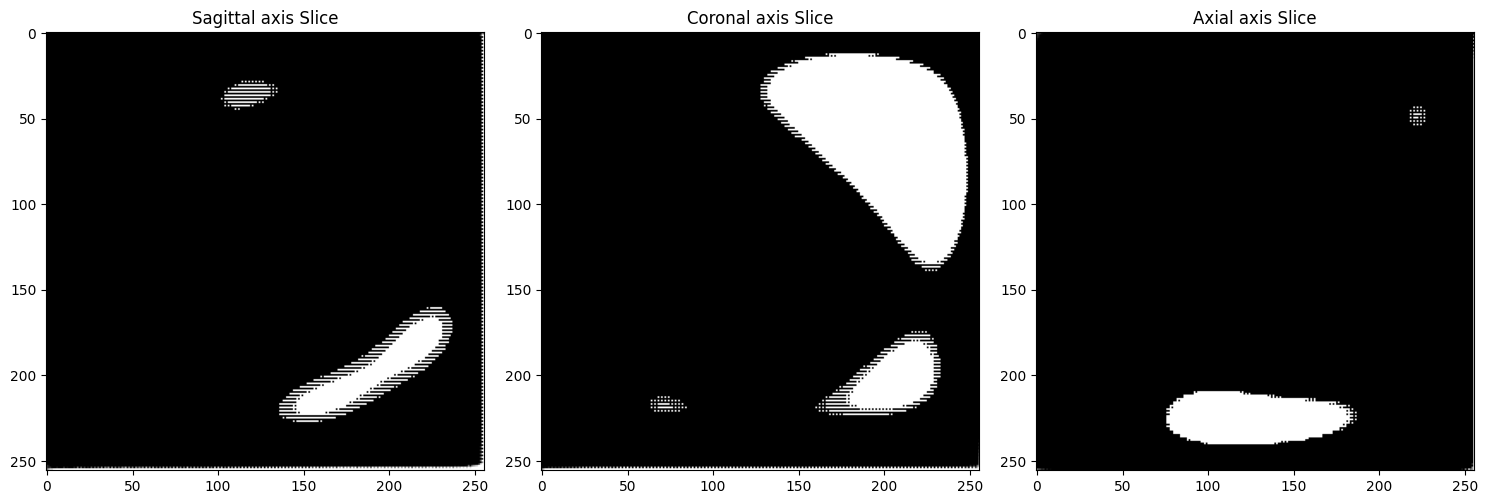

In [130]:
file_path = "C:\Studiet\Bachelor projekt\Code/3DStyleGAN-master/00089-generate-images\seed0066.nii.gz"
image_data = load_nifti(file_path)
plot_image(image_data, titel='')

## VAE GAN


Generating train and test dataset


In [685]:
num_data = 10
file_paths_flair = data_path_dict['BraTS2021']['flair']
file_paths_t1ce = data_path_dict['BraTS2021']['t1ce']
file_paths_t2 = data_path_dict['BraTS2021']['t2']
file_paths_t1 = data_path_dict['BraTS2021']['t1']
labels = data_path_dict['BraTS2021']['seg']
indexes = list(range(len(labels)))


In [484]:
Brats_train_path = 'Code/AE-GAN-main/data/BraTS2021_train'
Brats_test_path = 'Code/AE-GAN-main/data/BraTS2021_test'

In [485]:
def make_dataset_AE():
    train_flair_path = Brats_train_path + '/flair/'
    train_t1_path = Brats_train_path + '/t1/'
    train_t1ce_path = Brats_train_path + '/t1ce/'
    train_t2_path = Brats_train_path + '/t2/'
    print('Generating training set')
    for i in train_indexes:
        flair = prep(file_paths_flair[i])
        nib.save(flair, train_flair_path + f'BraTS2021_{i}_flair.nii.gz')
        t1 = prep(file_paths_t1[i])
        nib.save(t1, train_t1_path + f'BraTS2021_{i}_t1.nii.gz')
        t1ce = prep(file_paths_t1ce[i])
        nib.save(t1ce, train_t1ce_path + f'BraTS2021_{i}_t1ce.nii.gz')
        t2 = prep(file_paths_t2[i])
        nib.save(t2, train_t2_path + f'BraTS2021_{i}_t2.nii.gz')
    
    test_flair_path = Brats_test_path + '/flair/'
    test_t1_path = Brats_test_path + '/t1/'
    test_t1ce_path = Brats_test_path + '/t1ce/'
    test_t2_path = Brats_test_path + '/t2/'
    print('Generating test set')
    for i in test_indexes:
        flair = prep(file_paths_flair[i])
        nib.save(flair, test_flair_path + f'BraTS2021_{i}_flair.nii.gz')
        t1 = prep(file_paths_t1[i])
        nib.save(t1, test_t1_path + f'BraTS2021_{i}_t1.nii.gz')
        t1ce = prep(file_paths_t1ce[i])
        nib.save(t1ce, test_t1ce_path + f'BraTS2021_{i}_t1ce.nii.gz')
        t2 = prep(file_paths_t2[i])
        nib.save(t2, test_t2_path + f'BraTS2021_{i}_t2.nii.gz')
    print('done')
    


In [479]:
train_indexes_t, test_indexes_t, train_labels_t, test_labels_t = train_indexes, test_indexes, train_labels, test_labels

In [487]:

make_dataset_AE()

Generating training set


Generating test set
done


# Quality assesment


## SSIM

In [527]:
def ssim(image1, image2):
    data_range = np.max(image1) - np.min(image1)
    return structural_similarity(image1, image2, data_range=data_range, full=True)[0]

In [522]:
file1 = data_path_dict['BraTS2021']['t1'][0]
file2 = data_path_dict['BraTS2021']['t1'][1]
image_1 = load_nifti(file1)
image_2 = load_nifti(file2)

In [515]:
num_files = 10
SSIM = np.zeros((num_files, num_files))
files = data_path_dict['BraTS2021']['t1'][:num_files]
for i, file1 in enumerate(files):
    image_1 = load_nifti(file1)
    for j, file2 in enumerate(files):
        image_2 = load_nifti(file2)
        similarity = ssim(image_1,image_2)
        SSIM[i,j] = similarity


<Axes: >

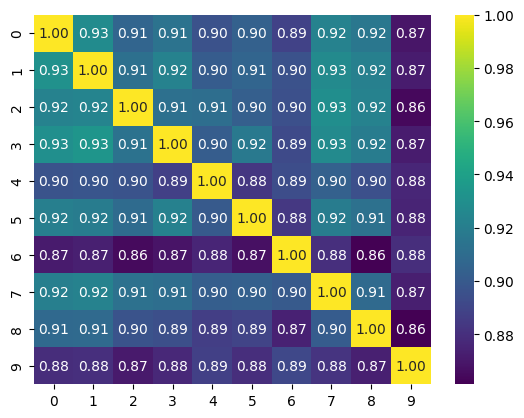

In [517]:
sns.heatmap(SSIM, annot=True, fmt=".2f", cmap="viridis", cbar=True)

## PSNR


In [530]:
def psnr(image1, image2):
    data_range = np.max(image1) - np.min(image1)
    mse = np.mean((image1 - image2) ** 2)

    if mse == 0:
        # Images are identical, PSNR is infinite
        return float('inf')
    return peak_signal_noise_ratio(image1, image2, data_range=data_range)

In [531]:
num_files = 10
PSNR = np.zeros((num_files, num_files))
files = data_path_dict['BraTS2021']['t1'][:num_files]
for i, file1 in enumerate(files):
    image_1 = load_nifti(file1)
    for j, file2 in enumerate(files):
        image_2 = load_nifti(file2)
        value = psnr(image_1,image_2)
        PSNR[i,j] = value

In [533]:
np.round(PSNR, 2)

array([[  inf, 26.97, 24.79, 24.55, 22.08, 18.56, 20.46, 25.98, 26.37,
        12.27],
       [28.09,   inf, 26.11, 25.2 , 23.  , 18.54, 23.77, 28.81, 27.13,
        13.  ],
       [29.01, 29.22,   inf, 26.85, 26.4 , 22.19, 24.86, 29.4 , 29.36,
        16.35],
       [29.28, 28.81, 27.35,   inf, 25.07, 23.15, 24.08, 28.45, 28.09,
        16.71],
       [22.23, 22.04, 22.33, 20.49,   inf, 17.95, 19.15, 22.48, 22.54,
        13.42],
       [24.88, 23.75, 24.29, 24.74, 24.13,   inf, 20.72, 23.86, 24.54,
        19.86],
       [10.17, 12.37, 10.35,  9.06,  8.71,  4.1 ,   inf, 12.41, 10.05,
         0.53],
       [25.63, 27.35, 24.82, 23.37, 21.97, 17.18, 22.35,   inf, 24.86,
        11.6 ],
       [23.75, 23.4 , 22.52, 20.74, 19.77, 15.6 , 17.72, 22.6 ,   inf,
         9.66],
       [20.93, 20.55, 20.79, 20.64, 21.93, 22.19, 19.48, 20.61, 20.93,
          inf]])

<Axes: >

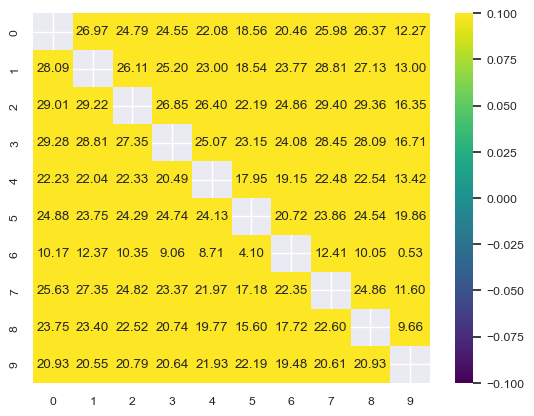

In [542]:
sns.set(font_scale=0.8)
sns.heatmap(PSNR, annot=True, fmt=".2f", cmap="viridis")

## FID

In [21]:
import torchvision.models as models

In [23]:
vgg16_model = models.vgg16(pretrained=True, progress=True).features

C:\Users\karlr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\karlr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [20]:
fid_metric = FID()


num_samples = 2

x_feats = torch.rand(num_samples, 4096)
y_feats = torch.rand(num_samples, 4096)

if torch.cuda.is_available():
    x_feats = x_feats.cuda()
    y_feats = y_feats.cuda()



fid: torch.Tensor = fid_metric(x_feats, y_feats)

In [17]:
fid

tensor(730.9797, dtype=torch.float64)

In [717]:
real_folder = 'Code\AE-GAN-main\data\BraTS2021_test/t1/'

batch_size = 2
print('Getting file paths')
real_file_paths = os.listdir(real_folder)



Getting file paths


## BRISQUE

In [20]:
test = data_path_dict['BraTS2021']['t1'][:126]

In [22]:
file1 = data_path_dict['BraTS2021']['t1'][0]
file2 = data_path_dict['BraTS2021']['t1'][1]
image_1 = load_nifti(file1)
image_2 = load_nifti(file2)

In [23]:
import torch
from piq import brisque

def normalize_image(image):

    normalized_image = torch.clamp(image, min=0)

    normalized_image = normalized_image / normalized_image.max()
    return normalized_image

def calculate_brisque(image, dim):

    image = torch.tensor(image)
    normalized_image = normalize_image(image)

    brisque_values = []


    for slice_index in range(normalized_image.shape[dim]):

        if dim == 0:

            slice_2d = normalized_image[slice_index, :, :]
        elif dim == 1:

            slice_2d = normalized_image[:, slice_index, :]
        elif dim == 2:

            slice_2d = normalized_image[:, :, slice_index]
        if torch.all(slice_2d == 0):
            continue

        slice_tensor = torch.tensor(slice_2d, dtype=torch.float32)

        brisque_value = brisque(slice_tensor.unsqueeze(0).unsqueeze(0))  

        brisque_values.append(brisque_value.item())

    return np.mean(np.array(brisque_values))


brisque_scores = calculate_brisque(image_1, 1)

print("BRISQUE scores for each 2D slice:")
print(brisque_scores)


C:\Users\karlr\AppData\Local\Temp\ipykernel_18424\897305352.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  slice_tensor = torch.tensor(slice_2d, dtype=torch.float32)


BRISQUE scores for each 2D slice:
93.88941464786642


In [25]:
scores = []
for file in test:
    try:
        image = load_nifti(file)
        score = calculate_brisque(image, 1)
        scores.append(score)
    except:
        print('error')
np.mean(scores)

C:\Users\karlr\AppData\Local\Temp\ipykernel_18424\897305352.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  slice_tensor = torch.tensor(slice_2d, dtype=torch.float32)


error
error


89.72295322145963

In [38]:
brisque_scores = calculate_brisque(image_1, 0)

print("BRISQUE scores for each 2D slice:")
print(brisque_scores)

brisque_scores = calculate_brisque(image_1, 1)

print("BRISQUE scores for each 2D slice:")
print(brisque_scores)

brisque_scores = calculate_brisque(image_1, 2)

print("BRISQUE scores for each 2D slice:")
print(brisque_scores)

C:\Users\karlr\AppData\Local\Temp\ipykernel_10480\897305352.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  slice_tensor = torch.tensor(slice_2d, dtype=torch.float32)


BRISQUE scores for each 2D slice:
89.7769380457261
BRISQUE scores for each 2D slice:
93.88941464786642
BRISQUE scores for each 2D slice:
73.18778845382063


# Generated vs real


In [66]:
brats_600_11_path = 'C:\Studiet\Bachelor projekt\Code\samples\sample_11_0.nii.gz'
brats_600_11 = load_nifti(brats_600_11_path)


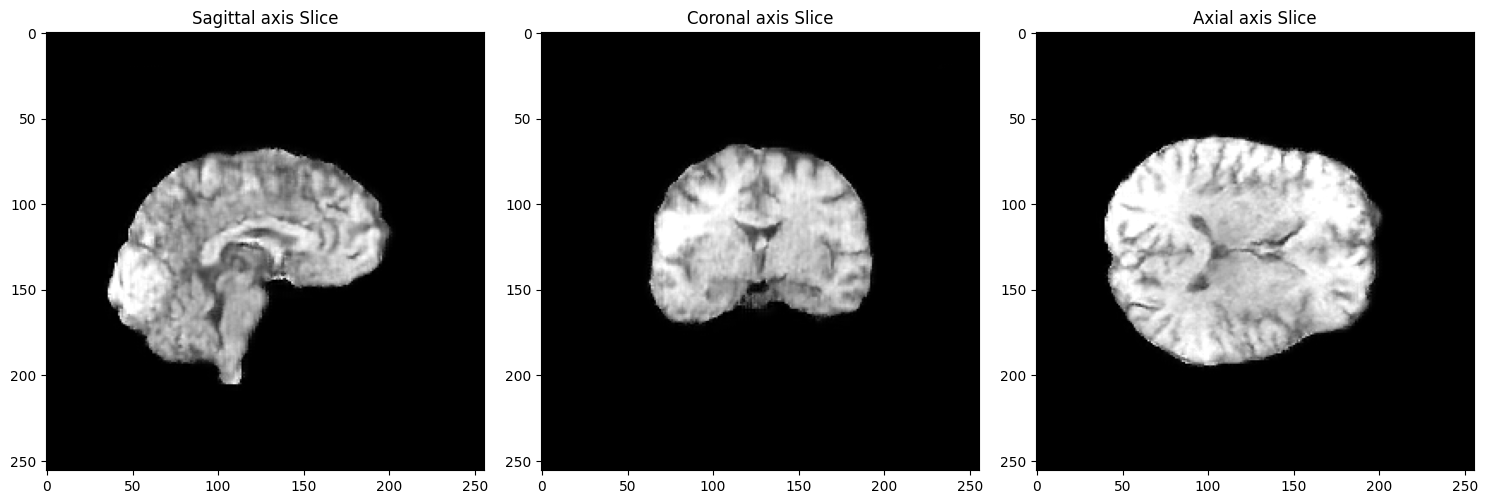

In [68]:
plot_image(brats_600_11, titel='')

In [87]:
real_brats = data_path_dict['BraTS2021']['t1'][17]
real_brats = load_nifti(real_brats)

In [88]:
plot_image(real_brats, titel='')